In [ ]:
!pip install gudhi
!pip install SimpleITK
!pip install nibabel


In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import cupy as cp
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from gudhi import CubicalComplex
from skimage import exposure, feature, filters
from skimage.feature import greycomatrix, greycoprops
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, wasserstein_distance
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from scipy.spatial.distance import cosine
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from scipy.stats import wasserstein_distance, entropy
from scipy.spatial.distance import jensenshannon

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extracting and Plotting Non-deep learning Features

In [ ]:
# Define the directory path for saving features
save_dir = '/content/drive/My Drive/Scorecard_Results/NonDeepFeatures'
os.makedirs(save_dir, exist_ok=True)

# List of datasets provided
datasets = {
    #'VinDr': '/content/drive/My Drive/Mammography_data_RS/Real_Mammography_Data/converted_HE_VinDr_images',
    'DDSM': '/content/drive/My Drive/Mammography_data_RS/Real_Mammography_Data/DDSM_all_images_cropped/DDSM_images_resized/DDSM_all_clean_all/center_cropped/equalized_images',
    #'InBreast': '/content/drive/My Drive/Mammography_data_RS/Real_Mammography_Data/INbreast_cropped_DICOM_images/INbreast_cropped_DICOM_images_resized/center_cropped/equalized_images',
    #'MIAS': '/content/drive/My Drive/Mammography_data_RS/Real_Mammography_Data/all-mias_cropped_images/all-mias_cropped_images_resized/center_cropped_clean_all_mias/equalized_images',
    'MSYNTH': '/content/drive/My Drive/Mammography_data_RS/SMD_datasets/All_images_Elena/Elena_images_resized/equalized_images',
    #'HuggingFace': '/content/drive/My Drive/Mammography_data_RS/SMD_datasets/HF_synthetic_mammography_csaw /center_cropped',
    #'Mammo_medigan': '/content/drive/My Drive/Mammography_data_RS/SMD_datasets/Mammo_medigan/medigan_images_resized/center_cropped'
}



In [ ]:
def compute_features(image_array):
    # Histogram-based features
    mean_val = np.mean(image_array)
    std_val = np.std(image_array)
    skewness = stats.skew(image_array.flatten())
    kurtosis = stats.kurtosis(image_array.flatten())
    median_val = np.median(image_array)

    # Edge-based features
    edges = feature.canny(image_array)
    edge_density = np.sum(edges) / edges.size
    avg_edge_intensity = np.mean(image_array[edges])

    # Fourier transform features
    f_transform = np.fft.fft2(image_array)
    f_transform_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shift)
    low_freq_energy = np.sum(magnitude_spectrum[:10, :10])
    high_freq_energy = np.sum(magnitude_spectrum[-10:, -10:])

    # Topological features using Persistent Homology
    cubical_complex = CubicalComplex(dimensions=image_array.shape, top_dimensional_cells=image_array.flatten())
    persistence = cubical_complex.persistence()
    betti_0 = sum(1 for p in persistence if p[0] == 0)
    betti_1 = sum(1 for p in persistence if p[0] == 1)

    features = [mean_val, std_val, skewness, kurtosis, median_val,
                edge_density, avg_edge_intensity, low_freq_energy, high_freq_energy,
                betti_0, betti_1]

    return features

# Define the feature columns
feature_columns = [
    'mean', 'std', 'skewness', 'kurtosis', 'median',
    'edge_density', 'avg_edge_intensity', 'low_freq_energy', 'high_freq_energy',
    'betti_0', 'betti_1'
]

In [ ]:
# Initialize a dictionary to store features for each dataset
dataset_features = {}

# Extract features for each dataset and save to the specified folder
for dataset_name, dataset_path in datasets.items():
    image_features = []
    all_files = [os.path.join(root, file)
                 for root, _, files in os.walk(dataset_path)
                 for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff', '.dicom', '.dcm'))]

    # Iterate through the selected image files with a progress bar
    for image_path in tqdm(all_files, desc=f'Processing {dataset_name}', unit='file'):
        img = Image.open(image_path).convert('L')
        img_array = np.array(img)
        features = compute_features(img_array)
        image_features.append(features)

    # Store extracted features in a DataFrame and save to CSV
    dataset_df = pd.DataFrame(image_features, columns=feature_columns)
    output_path = os.path.join(save_dir, f'{dataset_name}_features.csv')
    dataset_df.to_csv(output_path, index=False)
    dataset_features[dataset_name] = dataset_df

# Print summary information if needed
for dataset_name, features_df in dataset_features.items():
    print(f"Extracted features for {dataset_name}:")
    print(features_df.head())

Processing MSYNTH: 100%|██████████| 163/163 [02:43<00:00,  1.00s/file]

Extracted features for DDSM:
        mean        std  skewness  kurtosis  median  edge_density  \
0  33.924934  54.645414  1.372534  0.207675     3.0      0.045700   
1  36.616203  64.466843  1.686528  1.302805     3.0      0.036957   
2  33.535225  57.064805  1.593041  1.069201     3.0      0.046852   
3  62.550430  69.718014  0.564597 -1.252396     3.0      0.075603   
4  47.298672  61.370084  1.037142 -0.202601     3.0      0.062031   

   avg_edge_intensity  low_freq_energy  high_freq_energy  betti_0  betti_1  
0          119.204674     22871.585701      20752.678089     1756     2535  
1          117.403799     18679.065278      19100.473456     1434     2227  
2          117.688976     17776.034860      18095.256502     1179     1869  
3          125.732277     29172.996272      29910.564291     2321     3579  
4          113.170715     27411.181215      25996.099634     2453     3902  
Extracted features for MSYNTH:
        mean        std  skewness  kurtosis  median  edge_densi

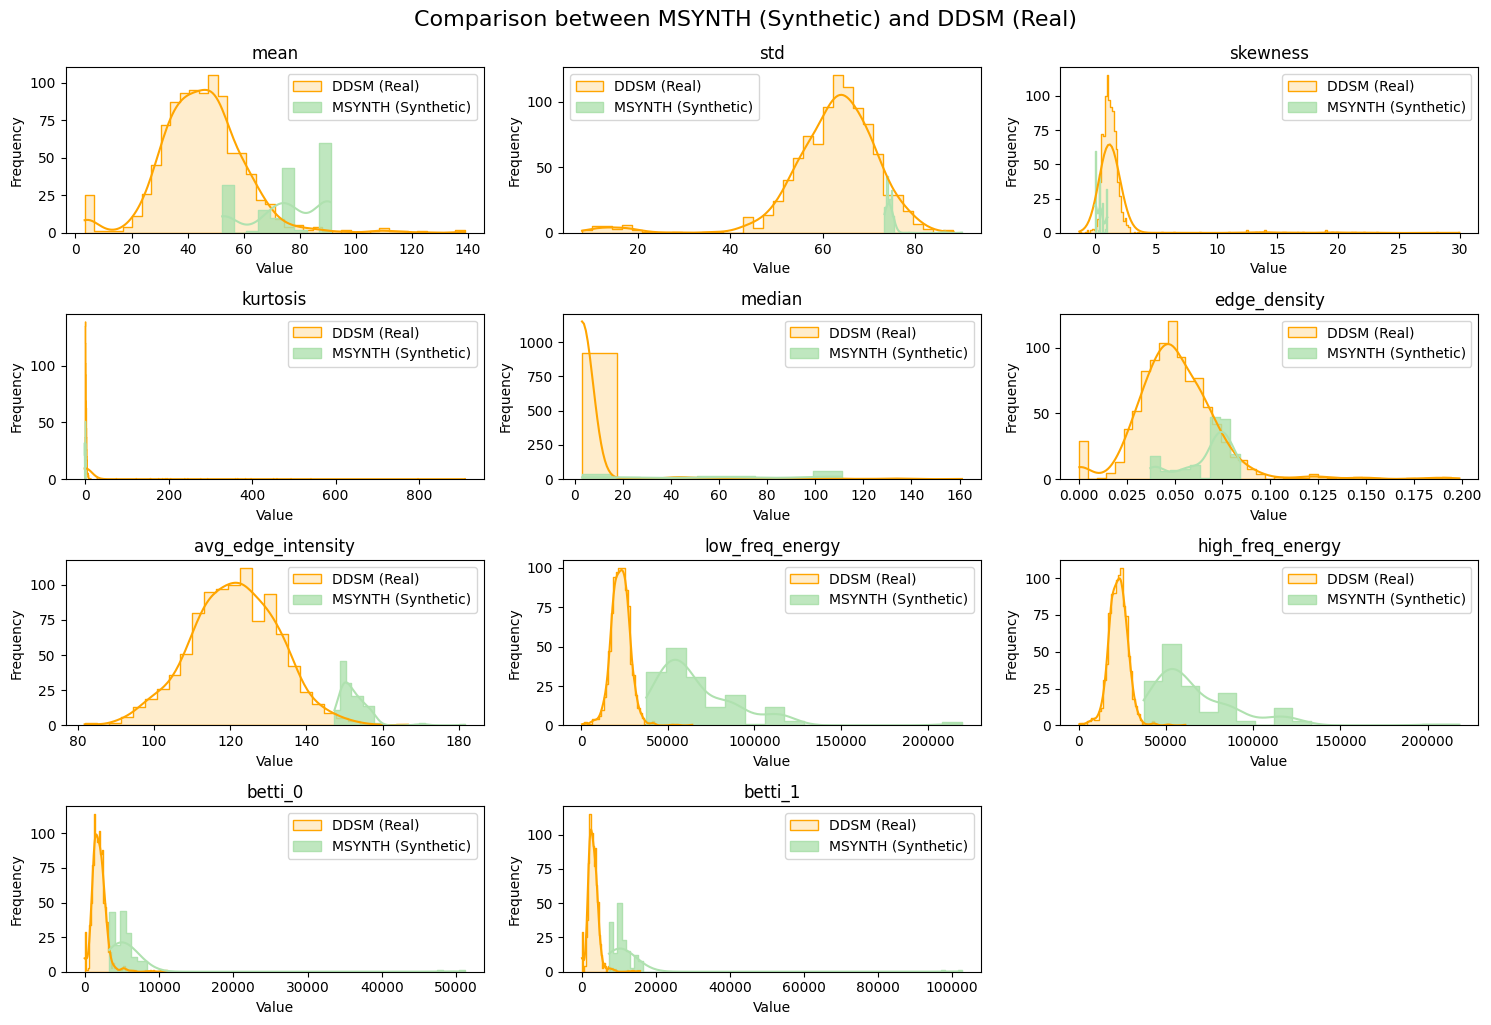

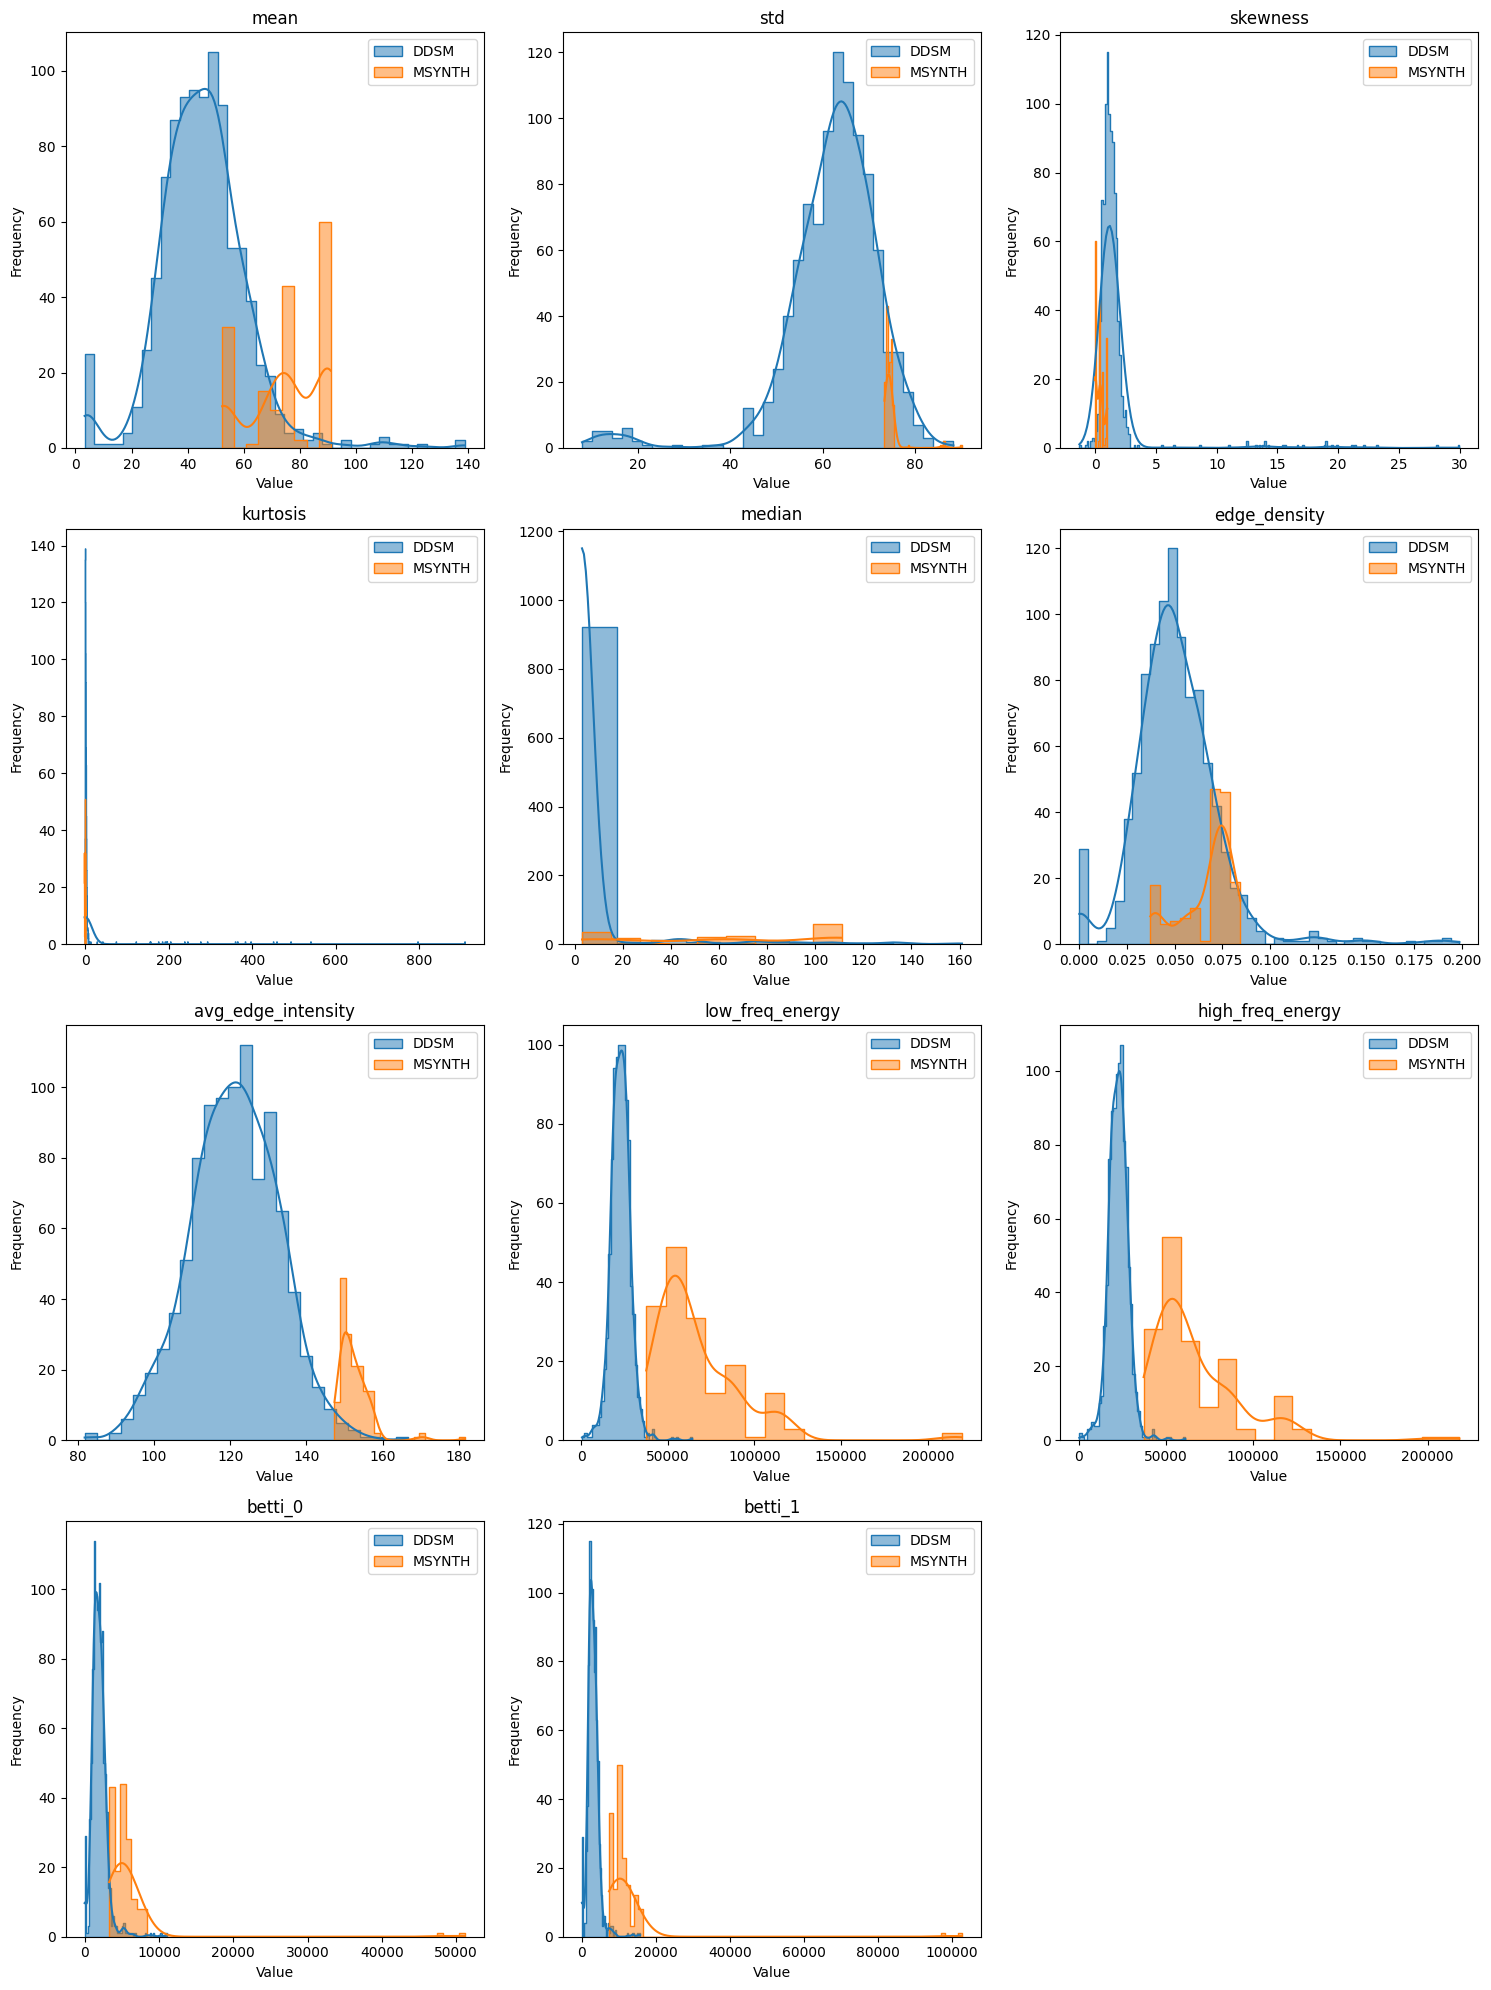

In [ ]:
# Define groups of synthetic and real datasets
#synthetic_datasets = ['MSYNTH', 'HuggingFace', 'Mammo_medigan']
#real_datasets = ['VinDr', 'DDSM', 'InBreast', 'MIAS']


synthetic_datasets = ['MSYNTH']
real_datasets = ['DDSM']

# Visualization parameters
real_transparency = 0.2  # Adjust transparency for real datasets
synthetic_color = '#AFE1AF'  # Distinctive color for synthetic datasets
figsize = (15, 10)  # Figure size for plots

# Function to plot comparison between synthetic and real datasets
def plot_synthetic_vs_real(synthetic, real):
    plt.figure(figsize=figsize)
    for i, column in enumerate(feature_columns):
        plt.subplot(4, 3, i + 1)  # Adjust grid size according to number of features
        # Plot real dataset histogram
        sns.histplot(dataset_features[real][column], kde=True, element='step',
                     label=f'{real} (Real)', color='orange', alpha=real_transparency)
        # Plot synthetic dataset histogram
        sns.histplot(dataset_features[synthetic][column], kde=True, element='step',
                     label=f'{synthetic} (Synthetic)', color=synthetic_color, alpha=0.8)
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.suptitle(f'Comparison between {synthetic} (Synthetic) and {real} (Real)', fontsize=16, y=1.02)
    plt.show()

def plot_all_datasets():
    plt.figure(figsize=(15, 20))  # Adjust size to better fit a larger grid
    for i, column in enumerate(feature_columns):
        plt.subplot(4, 3, i + 1)  # Adjust to a 4x3 grid
        for dataset_name, dataset_df in dataset_features.items():
            sns.histplot(dataset_df[column], label=dataset_name, kde=True, element='step')
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()



# Plot comparisons between synthetic and real datasets
for synthetic in synthetic_datasets:
    for real in real_datasets:
        plot_synthetic_vs_real(synthetic, real)

# Plot all datasets together
plot_all_datasets()


# Extracting and Plotting Deep learning Features

In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define a custom dataset class for images
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path


# Load a pre-trained ResNet model and modify it
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the last layer
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Function to extract features using the model
def extract_features(loader, model, device):
    features = []
    paths = []
    with torch.no_grad():
        for imgs, img_paths in tqdm(loader):
            imgs = imgs.to(device)
            outputs = model(imgs)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten the features
            features.append(outputs.cpu().numpy())
            paths.extend(img_paths)
    features = np.concatenate(features, axis=0)
    return features, paths


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]


In [ ]:

# Initialize a dictionary to store features for each dataset
dataset_deep_features = {}

# Extract features for each dataset and save to the specified folder
for dataset_name, dataset_path in datasets.items():
    # Get all image files in the dataset path
    all_files = [os.path.join(root, file)
                 for root, _, files in os.walk(dataset_path)
                 for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff', '.dicom', '.dcm'))]

    dataset = ImageDataset(all_files, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

    features, paths = extract_features(loader, model, device)
    dataset_deep_features[dataset_name] = (features, paths)

    # Save features to a CSV file
    features_df = pd.DataFrame(features)
    output_path = os.path.join(save_dir, f'{dataset_name}_deep_features.csv')
    features_df.to_csv(output_path, index=False)


100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


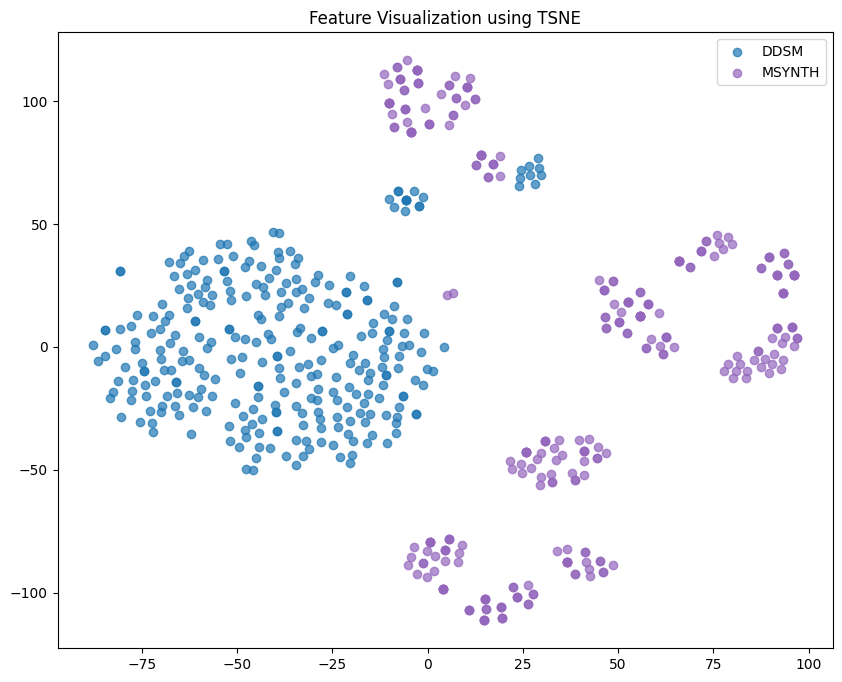

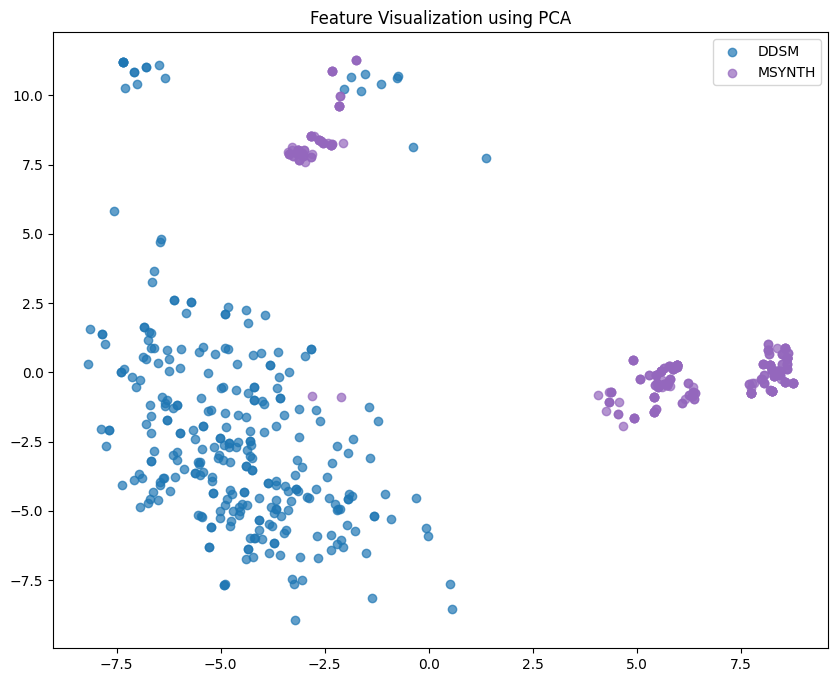

In [ ]:

# Define a distinct color palette for the datasets
dataset_colors = {
    'DDSM': '#1f77b4',  # blue
    #'HuggingFace': '#ff7f0e',  # orange
    #'InBreast': '#2ca02c',  # green
    #'MIAS': '#d62728',  # red
    'MSYNTH': '#9467bd',  # purple
    #'Mammo_medigan': '#8c564b',  # brown
    #'VinDr': '#e377c2'  # pink
}

# Function to visualize features
def visualize_features(features, labels, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        reducer = PCA(n_components=2)

    reduced_features = reducer.fit_transform(features)

    plt.figure(figsize=(10, 8))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=label, color=dataset_colors[label], alpha=0.7)
    plt.legend()
    plt.title(f'Feature Visualization using {method.upper()}')
    plt.show()

# Randomly select 300 images from each dataset for visualization
sampled_features = []
sampled_labels = []
for dataset_name, (features, paths) in dataset_deep_features.items():
    indices = np.random.choice(len(features), 300, replace=True)
    sampled_features.append(features[indices])
    sampled_labels.extend([dataset_name] * 300)

sampled_features = np.concatenate(sampled_features, axis=0)
sampled_labels = np.array(sampled_labels)

# Visualize using t-SNE
visualize_features(sampled_features, sampled_labels, method='tsne')

# Visualize using PCA
visualize_features(sampled_features, sampled_labels, method='pca')


In [ ]:
# Create a summary DataFrame for all datasets combined
summary_list = []

for dataset_name, (features, paths) in dataset_deep_features.items():
    features_df = pd.DataFrame(features)
    summary_stats = features_df.describe().loc[['mean', 'std', 'min', 'max']].stack()
    summary_list.append(pd.Series(summary_stats, name=dataset_name))

# If the summary list isn't empty, concatenate into a final DataFrame
if summary_list:
    summary_df = pd.concat(summary_list, axis=1).transpose()
    summary_output_path = os.path.join(save_dir, 'deep_features_summary.csv')
    summary_df.to_csv(summary_output_path, index=True)

    # Print the summary table directly to the console
    print("Summary of Deep Features by Dataset:")
    print(summary_df)
else:
    print("No features extracted to create a summary. Check the datasets for validity.")


Summary of Deep Features by Dataset:
            mean                                                              \
            0         1         2         3         4         5         6      
DDSM    0.396425  0.386112  0.124121  0.047662  0.125179  0.491362  0.358289   
MSYNTH  0.485271  0.649353  0.054620  0.088678  0.029402  0.188106  0.385503   

                                      ...       max                      \
            7         8         9     ...      2038      2039      2040   
DDSM    0.330331  0.664794  0.306672  ...  0.915871  1.377596  0.800125   
MSYNTH  0.377989  0.530339  0.627542  ...  0.394091  0.913908  0.284095   

                                                                              
            2041      2042      2043      2044      2045      2046      2047  
DDSM    1.011932  1.404259  0.144155  0.708052  0.661621  2.409349  1.499362  
MSYNTH  0.822784  0.368122  0.214572  0.407870  0.186263  1.888796  1.036298  

[2 rows x 8192 columns]


#Compute Correctness Metrics using the Extracted Features
dataset_features

dataset_deep_features

In [ ]:


# Function to compute similarity metrics
def compute_similarity_metrics(real_df, synthetic_df):
    # Downsample the larger dataset to match the smaller dataset size
    min_samples = min(len(real_df), len(synthetic_df))
    real_df_sampled = real_df.sample(n=min_samples, random_state=42)
    synthetic_df_sampled = synthetic_df.sample(n=min_samples, random_state=42)

    metrics = {}
    for column in feature_columns:
        real_features = real_df_sampled[column].values
        synthetic_features = synthetic_df_sampled[column].values

        # Compute Earth Mover's Distance
        emd = wasserstein_distance(real_features, synthetic_features)

        # Compute Cosine Similarity
        cos_sim = 1 - cosine(real_features, synthetic_features)

        # Compute Pearson Correlation
        pearson_corr, _ = pearsonr(real_features, synthetic_features)

        metrics[column] = {'EMD': emd, 'Cosine Similarity': cos_sim, 'Pearson Correlation': pearson_corr}
    return metrics

# Initialize a dictionary to store similarity metrics
similarity_metrics = {}

# Compute similarity metrics for each synthetic-real dataset pair
for synthetic in synthetic_datasets:
    for real in real_datasets:
        real_df = dataset_features[real]
        synthetic_df = dataset_features[synthetic]
        metrics = compute_similarity_metrics(real_df, synthetic_df)
        similarity_metrics[(synthetic, real)] = metrics

# Create a summary DataFrame for the correctness metrics
summary_list = []

for (synthetic, real), metrics in similarity_metrics.items():
    for feature, values in metrics.items():
        summary_list.append({
            'Synthetic Dataset': synthetic,
            'Real Dataset': real,
            'Feature': feature,
            'EMD': values['EMD'],
            'Cosine Similarity': values['Cosine Similarity'],
            'Pearson Correlation': values['Pearson Correlation']
        })

summary_df = pd.DataFrame(summary_list)

# Save the summary to a CSV file
summary_output_path = os.path.join(save_dir, 'correctness_metrics_summary.csv')
summary_df.to_csv(summary_output_path, index=False)

# Print the summary table
print("Summary of Correctness Metrics by Synthetic-Real Dataset Pair:")
print(summary_df)


Summary of Correctness Metrics by Synthetic-Real Dataset Pair:
   Synthetic Dataset Real Dataset             Feature           EMD  \
0             MSYNTH         DDSM                mean     32.261715   
1             MSYNTH         DDSM                 std     13.303285   
2             MSYNTH         DDSM            skewness      1.329470   
3             MSYNTH         DDSM            kurtosis     10.043648   
4             MSYNTH         DDSM              median     56.110429   
5             MSYNTH         DDSM        edge_density      0.020834   
6             MSYNTH         DDSM  avg_edge_intensity     32.349775   
7             MSYNTH         DDSM     low_freq_energy  45285.194044   
8             MSYNTH         DDSM    high_freq_energy  45175.682313   
9             MSYNTH         DDSM             betti_0   3828.601227   
10            MSYNTH         DDSM             betti_1   8788.797546   

    Cosine Similarity  Pearson Correlation  
0            0.935030            -0.084

In [ ]:
import pandas as pd
from scipy.stats import wasserstein_distance, pearsonr
from scipy.spatial.distance import cosine
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

def compute_similarity_metrics(real_df, synthetic_df):
    # Downsample the larger dataset to match the smaller dataset size
    min_samples = min(len(real_df), len(synthetic_df))
    real_df_sampled = real_df.sample(n=min_samples, random_state=42)
    synthetic_df_sampled = synthetic_df.sample(n=min_samples, random_state=42)

    metrics = {}
    for column in feature_columns:
        real_features = real_df_sampled[column].values
        synthetic_features = synthetic_df_sampled[column].values

        # Compute Earth Mover's Distance
        emd = wasserstein_distance(real_features, synthetic_features)

        # Compute Cosine Similarity
        cos_sim = 1 - cosine(real_features, synthetic_features)

        # Compute Pearson Correlation
        pearson_corr, _ = pearsonr(real_features, synthetic_features)

        # Image Quality Metrics (assuming the features are image data)
        if column == 'image_data':  # 'image_data' should be replaced with actual image column if available
            psnr_value = psnr(real_features, synthetic_features)
            ssim_value = ssim(real_features, synthetic_features)
        else:
            psnr_value = np.nan
            ssim_value = np.nan

        metrics[column] = {
            'EMD': emd,
            'Cosine Similarity': cos_sim,
            'Pearson Correlation': pearson_corr,
            'PSNR': psnr_value,
            'SSIM': ssim_value
        }
    return metrics

# Initialize a dictionary to store similarity metrics
similarity_metrics = {}

# Compute similarity metrics for each synthetic-real dataset pair
for synthetic in synthetic_datasets:
    for real in real_datasets:
        real_df = dataset_features[real]
        synthetic_df = dataset_features[synthetic]
        metrics = compute_similarity_metrics(real_df, synthetic_df)
        similarity_metrics[(synthetic, real)] = metrics

# Create a summary DataFrame for the correctness metrics
summary_list = []

for (synthetic, real), metrics in similarity_metrics.items():
    for feature, values in metrics.items():
        summary_list.append({
            'Synthetic Dataset': synthetic,
            'Real Dataset': real,
            'Feature': feature,
            'EMD': values['EMD'],
            'Cosine Similarity': values['Cosine Similarity'],
            'Pearson Correlation': values['Pearson Correlation'],
            'PSNR': values['PSNR'],
            'SSIM': values['SSIM']
        })

summary_df = pd.DataFrame(summary_list)

# Save the summary to a CSV file
summary_output_path = os.path.join(save_dir, 'correctness_metrics_summary.csv')
summary_df.to_csv(summary_output_path, index=False)  # Correct usage of the file path

# Print the summary table
print("Summary of Correctness Metrics by Synthetic-Real Dataset Pair:")
print(summary_df)


# Print the summary table
print("Summary of Correctness Metrics by Synthetic-Real Dataset Pair:")
print(summary_df)


Summary of Correctness Metrics by Synthetic-Real Dataset Pair:
   Synthetic Dataset Real Dataset             Feature           EMD  \
0             MSYNTH         DDSM                mean     32.261715   
1             MSYNTH         DDSM                 std     13.303285   
2             MSYNTH         DDSM            skewness      1.329470   
3             MSYNTH         DDSM            kurtosis     10.043648   
4             MSYNTH         DDSM              median     56.110429   
5             MSYNTH         DDSM        edge_density      0.020834   
6             MSYNTH         DDSM  avg_edge_intensity     32.349775   
7             MSYNTH         DDSM     low_freq_energy  45285.194044   
8             MSYNTH         DDSM    high_freq_energy  45175.682313   
9             MSYNTH         DDSM             betti_0   3828.601227   
10            MSYNTH         DDSM             betti_1   8788.797546   

    Cosine Similarity  Pearson Correlation  PSNR  SSIM  
0            0.935030      

In [ ]:
# List of real dataset names
synthetic_dataset_name = ['MSYNTH']
real_dataset_name = ['DDSM']


# Sample usage: Calculate metrics between matched real and synthetic datasets
for real, synthetic in zip(real_datasets, synthetic_datasets):
    real_features = dataset_features[real].mean().values
    synthetic_features = dataset_features[synthetic].mean().values

    # Calculate and print various comparison metrics
    print(f"Comparing {real} to {synthetic}")
    stat_distances = calculate_statistical_distances(real_features, synthetic_features)
    print(f"Statistical Distances: {stat_distances}")
    cos_sim = calculate_cosine_similarity(real_features, synthetic_features)
    print(f"Cosine Similarity: {cos_sim}")


Comparing DDSM to MSYNTH
Statistical Distances: (9255.100019520496, inf, inf)
Cosine Similarity: 0.9995944071978909


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import SimpleITK as sitk
from skimage.feature import greycomatrix, greycoprops
from scipy import ndimage
from scipy.stats import kurtosis, skew
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms


In [ ]:

# Directory for saving features
save_dir = '/content/drive/My Drive/Scorecard_Results/3DFeatures'
os.makedirs(save_dir, exist_ok=True)




In [ ]:
# Sample dataset paths
datasets = {
    'Sarno-DBT': '/content/drive/My Drive/CT-2',
    #'Duke-DBT': '/path_to_data'
}

def compute_3d_features(image_3d):
    # Voxel-wise mean, standard deviation, skewness, and kurtosis
    mean_val = np.mean(image_3d)
    std_val = np.std(image_3d)
    skewness = skew(image_3d, axis=None)
    kurtosis_val = kurtosis(image_3d, axis=None)

    # Edge detection in 3D
    edges = feature.canny(image_3d)  # Note: Replace with a 3D edge detection if available
    edge_density = np.sum(edges) / edges.size

    # 3D Fourier transform features
    f_transform = np.fft.fftn(image_3d)
    f_transform_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shift)
    low_freq_energy = np.sum(magnitude_spectrum[:10, :10, :10])
    high_freq_energy = np.sum(magnitude_spectrum[-10:, -10:, -10:])

    features = [mean_val, std_val, skewness, kurtosis_val, edge_density, low_freq_energy, high_freq_compile]
    return features

def load_3d_image(path_to_dicom_series):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(path_to_dicom_series)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_array = sitk.GetArrayFromImage(image)  # Convert to numpy array
    return image_array

def compute_3d_features(image_3d):
    # Calculate 3D image statistics and other features
    mean_val = np.mean(image_3d)
    std_val = np.std(image_3d)
    skewness = np.percentile(image_3d, 50)  # Using percentile for robustness
    kurtosis_val = np.max(image_3d)  # Example of using max as a feature

    # Additional features can be added here
    features = [mean_val, std_val, skewness, kurtosis_val]
    return features

def load_3d_nifti_image(path_to_nifti_file):
    nifti_img = nib.load(path_to_nifti_file)
    image_data = nifti_img.get_fdata()  # Converts NIfTI file to a numpy array
    return image_data

In [ ]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm
import pandas as pd


# Process each dataset
for dataset_name, dataset_path in datasets.items():
    image_features = []
    all_files = [f for f in os.listdir(dataset_path) if f.endswith('.nii')]

    for file_name in tqdm(all_files, desc=f'Processing {dataset_name}', unit='file'):
        image_path = os.path.join(dataset_path, file_name)
        image_3d = load_3d_nifti_image(image_path)
        features = compute_3d_features(image_3d)
        image_features.append(features)

    # Save features to CSV
    feature_columns = ['mean', 'std', '50th_percentile', 'max_value']
    dataset_df = pd.DataFrame(image_features, columns=feature_columns)
    output_path = os.path.join(save_dir, f'{dataset_name}_features.csv')
    dataset_df.to_csv(output_path, index=False)

    print(f"Extracted features for {dataset_name}:")
    print(dataset_df.head())

# Further operations such as plotting or advanced analysis can continue from here

Processing Sarno-DBT: 100%|██████████| 125/125 [00:39<00:00,  3.20file/s]

Extracted features for Sarno-DBT:
         mean         std  50th_percentile  max_value
0 -890.445368  744.556884           -981.0     1771.0
1 -733.164325  801.494360           -785.0     1843.0
2 -774.282834  785.073788           -851.0     1828.0
3 -760.490106  795.902238           -831.0     1721.0
4 -771.230251  798.132989           -877.0     1771.0


In [ ]:
print(output_path)

/content/drive/My Drive/Scorecard_Results/3DFeatures/Sarno-DBT_features.csv


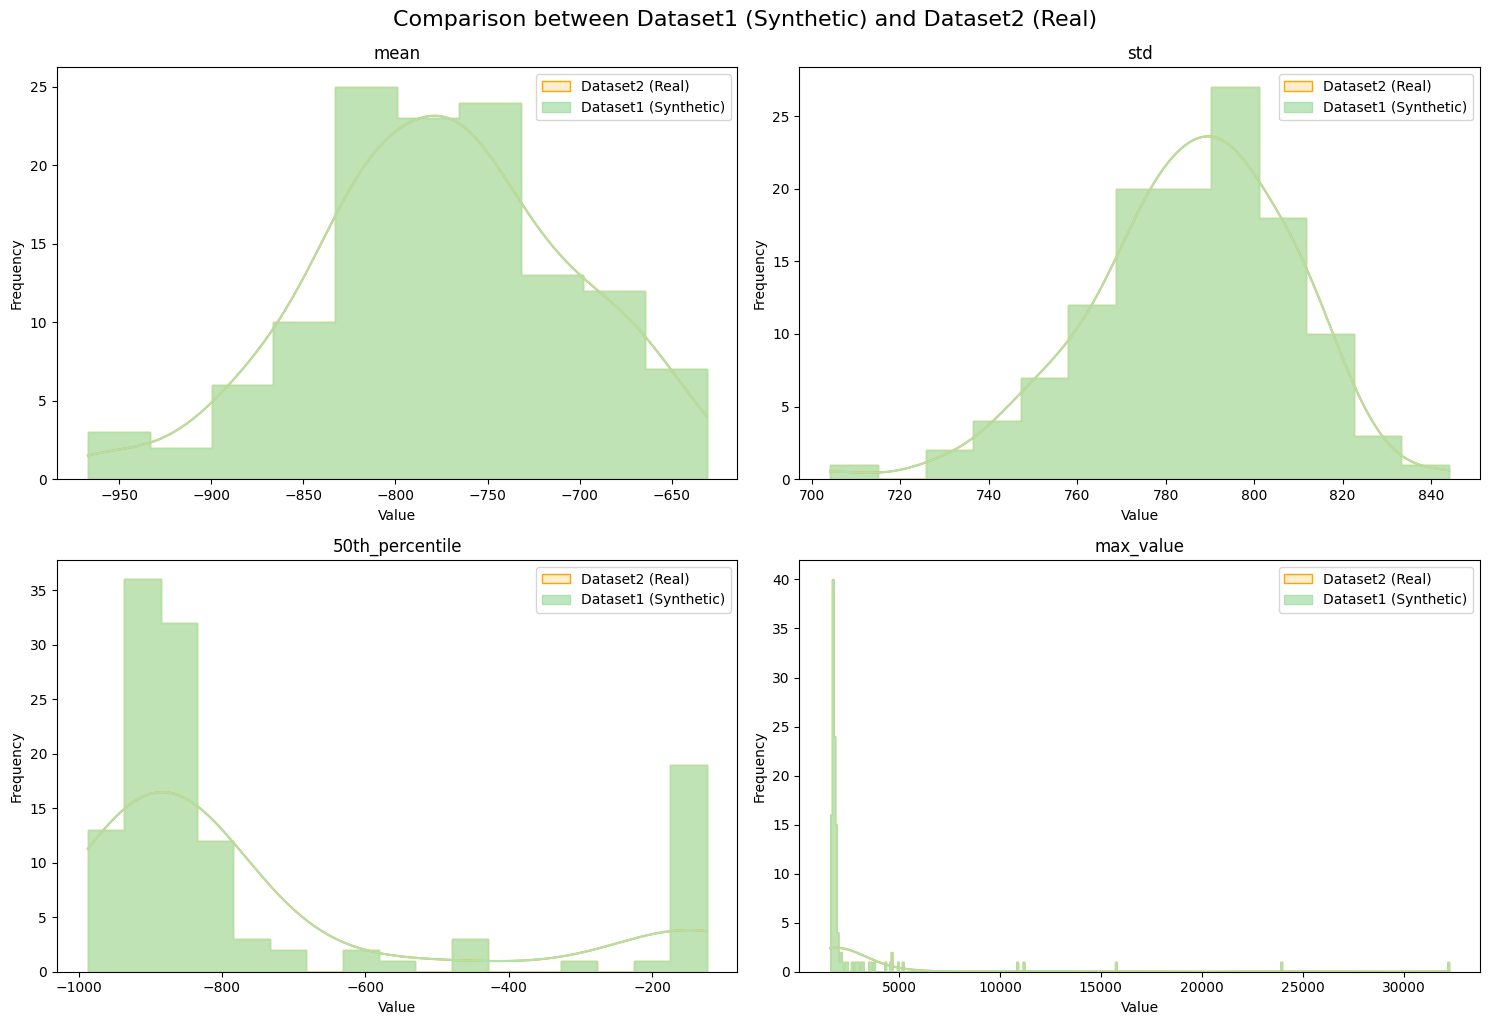

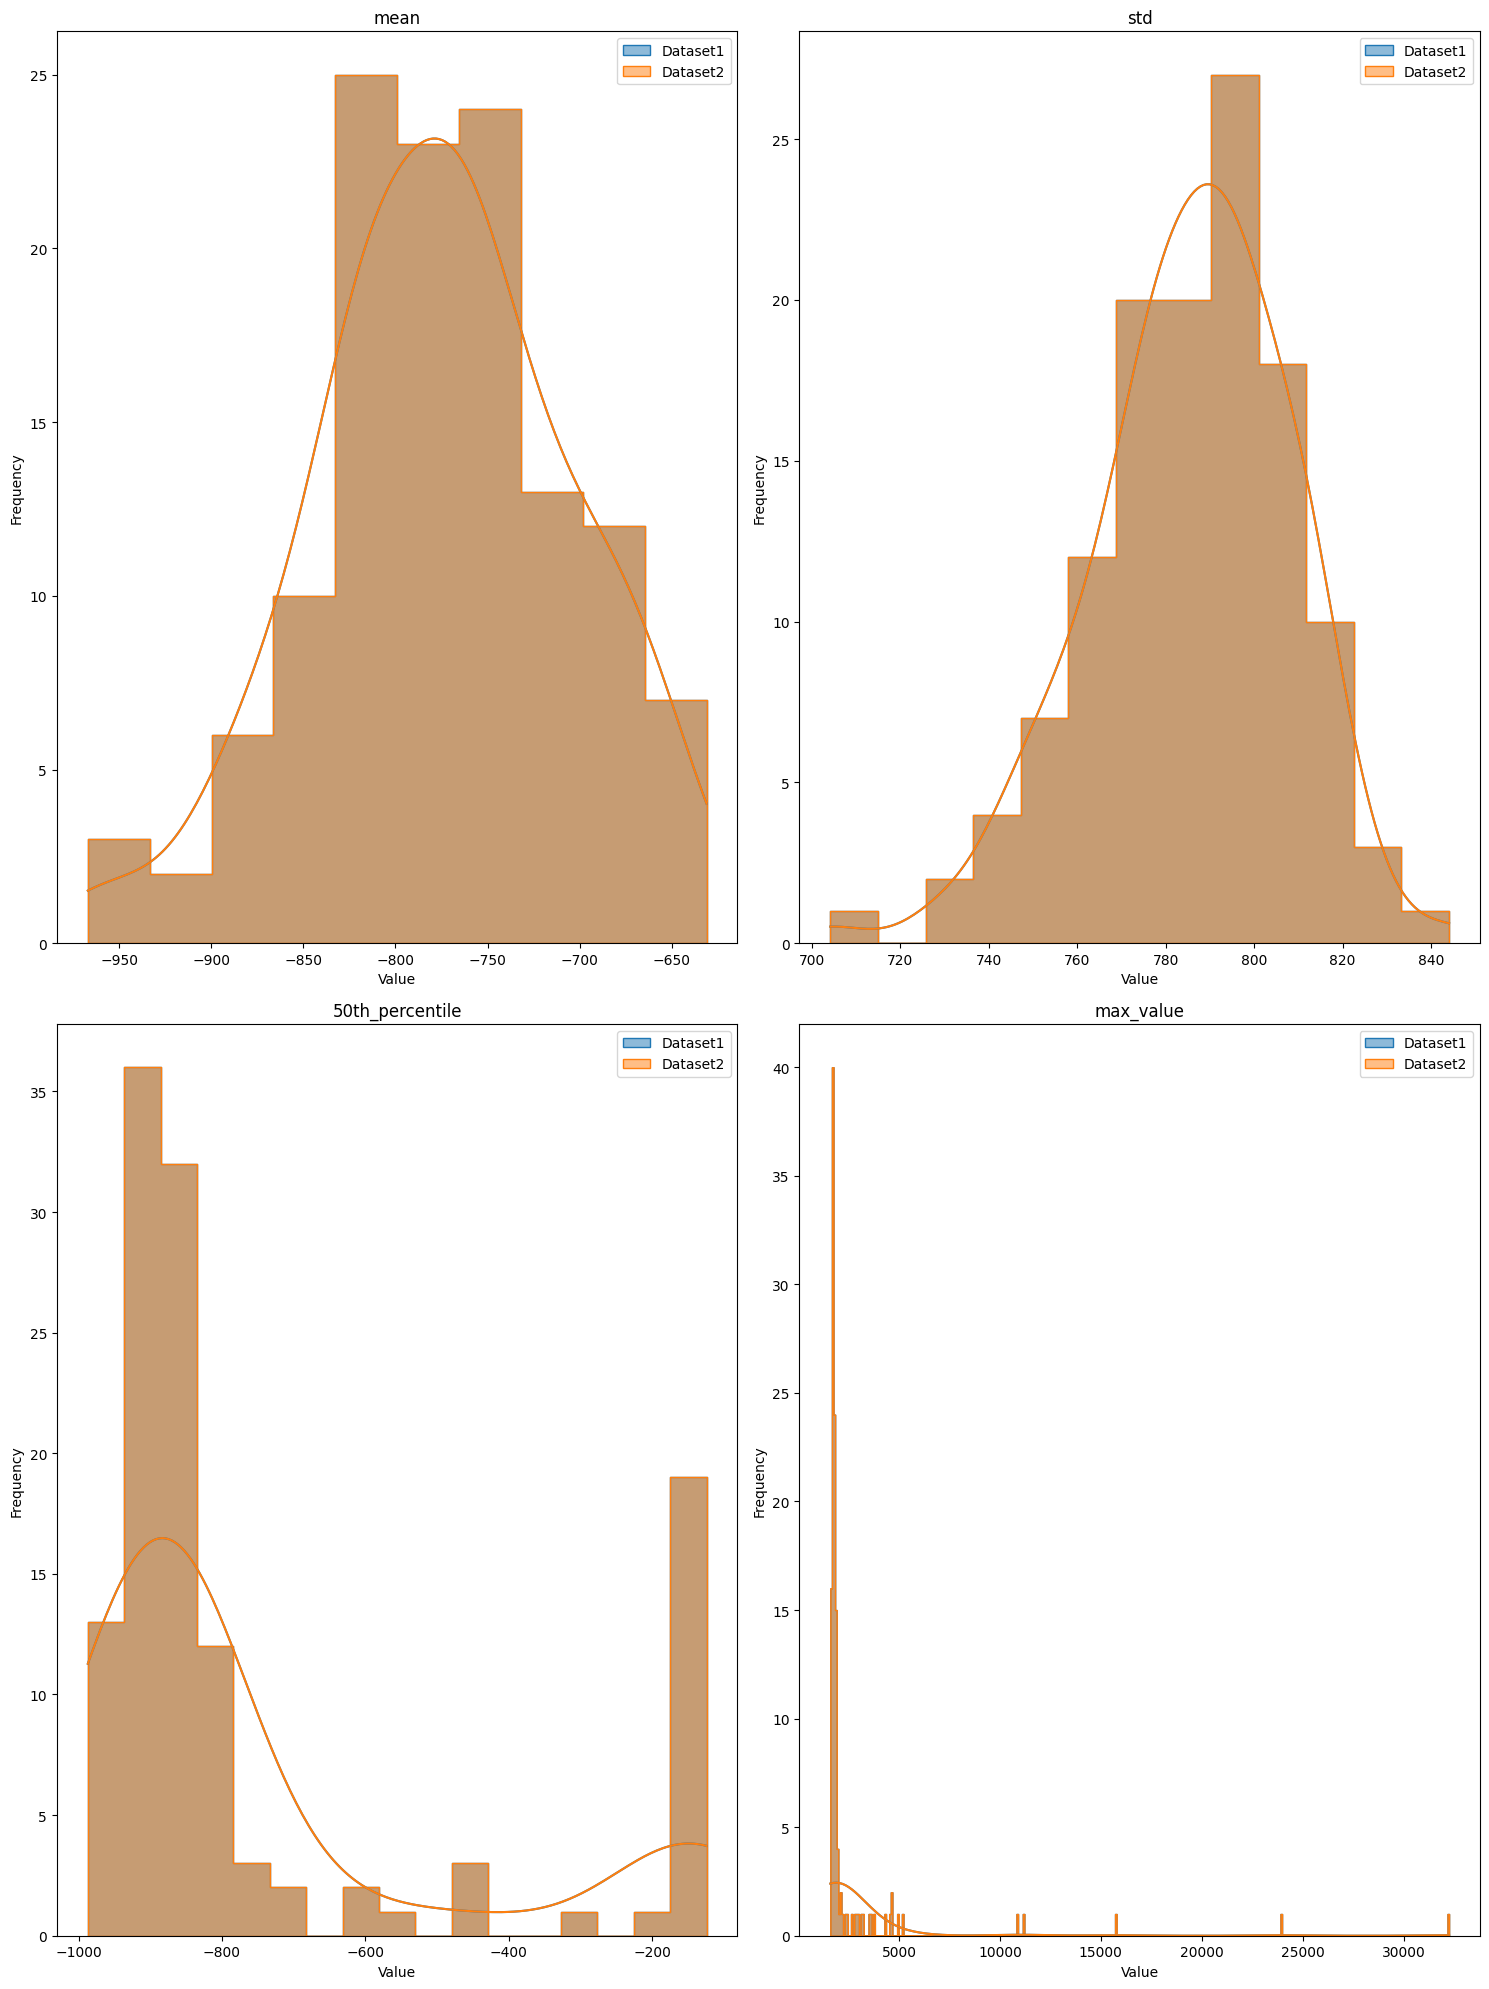

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the paths to the feature CSV files
datasets = {
    'Dataset1': '/content/drive/My Drive/Scorecard_Results/3DFeatures/Sarno-DBT_features.csv',
    'Dataset2': '/content/drive/My Drive/Scorecard_Results/3DFeatures/Sarno-DBT_features.csv'
}

# Define feature columns as they are stored in your DataFrame
feature_columns = ['mean', 'std', '50th_percentile', 'max_value']

# Visualization parameters
real_transparency = 0.2  # Transparency for histograms of real datasets
synthetic_color = '#AFE1AF'  # Distinctive color for synthetic datasets
figsize = (15, 10)  # Overall size of the figure

# Load the dataset features from CSV
dataset_features = {}
for dataset_name, file_path in datasets.items():
    dataset_features[dataset_name] = pd.read_csv(file_path)

def plot_synthetic_vs_real(synthetic, real):
    plt.figure(figsize=figsize)
    for i, column in enumerate(feature_columns):
        plt.subplot(2, 2, i + 1)  # Ensure grid size is sufficient for the number of features
        # Real dataset histogram
        sns.histplot(dataset_features[real][column], kde=True, element='step',
                     label=f'{real} (Real)', color='orange', alpha=real_transparency)
        # Synthetic dataset histogram
        sns.histplot(dataset_features[synthetic][column], kde=True, element='step',
                     label=f'{synthetic} (Synthetic)', color=synthetic_color, alpha=0.8)
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.suptitle(f'Comparison between {synthetic} (Synthetic) and {real} (Real)', fontsize=16, y=1.02)
    plt.show()

def plot_all_datasets():
    plt.figure(figsize=(15, 20))  # Larger grid for better visibility
    for i, column in enumerate(feature_columns):
        plt.subplot(2, 2, i + 1)  # Adjust grid to match the number of features
        for dataset_name, dataset_df in dataset_features.items():
            sns.histplot(dataset_df[column], label=dataset_name, kde=True, element='step')
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Example usage
synthetic_datasets = ['Dataset1']  # Define your synthetic datasets here
real_datasets = ['Dataset2']  # Define your real datasets here

# Execute the plotting functions
for synthetic in synthetic_datasets:
    for real in real_datasets:
        plot_synthetic_vs_real(synthetic, real)  # Compare synthetic and real datasets

plot_all_datasets()  # Plot histograms for all datasets together


In [ ]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm
import pandas as pd
from scipy.stats import skew, kurtosis
from skimage import filters, measure
import scipy.fftpack as fft

# Define the feature columns
feature_columns = [
    'mean', 'std', 'skewness', 'kurtosis', 'median',
    'edge_density', 'avg_edge_intensity', 'low_freq_energy', 'high_freq_energy',
    'betti_0', 'betti_1'
]


# Define the paths to the feature CSV files
datasets = {
    'Sarno-DBT': '/content/drive/My Drive/CT-2',
    #'Dataset2': '/content/drive/My Drive/Scorecard_Results/3DFeatures/Sarno-DBT_features.csv'
}


# Dummy function for Betti numbers calculation (replace with actual implementation)
def compute_betti_numbers(image_3d):
    # Placeholder for actual Betti number calculation
    betti_0 = np.random.rand()  # Dummy value
    betti_1 = np.random.rand()  # Dummy value
    return betti_0, betti_1

# Function to compute features from a 3D image
def compute_3d_features(image_3d):
    if image_3d is None:
        return [np.nan] * len(feature_columns)

    mean_val = np.mean(image_3d)
    std_val = np.std(image_3d)
    skewness = skew(image_3d.flatten())
    kurt = kurtosis(image_3d.flatten())
    median_val = np.median(image_3d)

    edges = filters.sobel(image_3d)
    edge_density = np.mean(edges > 0)
    avg_edge_intensity = np.mean(edges[edges > 0])

    low_freq_energy = np.mean(np.abs(fft.fftn(image_3d))[:5])
    high_freq_energy = np.mean(np.abs(fft.fftn(image_3d))[-5:])

    betti_0, betti_1 = compute_betti_numbers(image_3d)

    return [
        mean_val, std_val, skewness, kurt, median_val,
        edge_density, avg_edge_intensity, low_freq_energy, high_freq_energy,
        betti_0, betti_1
    ]

# Process each dataset
for dataset_name, dataset_path in datasets.items():
    image_features = []
    all_files = [f for f in os.listdir(dataset_path) if f.endswith('.nii')]

    for file_name in tqdm(all_files, desc=f'Processing {dataset_name}', unit='file'):
        image_path = os.path.join(dataset_path, file_name)
        image_3d = load_3d_nifti_image(image_path)
        features = compute_3d_features(image_3d)
        image_features.append(features)

    # Save features to CSV
    dataset_df = pd.DataFrame(image_features, columns=feature_columns)
    output_path = os.path.join(save_dir, f'{dataset_name}_features.csv')
    dataset_df.to_csv(output_path, index=False)

    print(f"Extracted features for {dataset_name}:")
    print(dataset_df.head())

# Further operations such as plotting or advanced analysis can continue from here


Processing Sarno-DBT: 100%|██████████| 125/125 [11:23<00:00,  5.47s/file]

Extracted features for Sarno-DBT:
         mean         std  skewness  kurtosis  median  edge_density  \
0 -890.445368  744.556884 -0.186935 -0.877029  -981.0      0.792725   
1 -733.164325  801.494360 -0.531709 -0.951950  -785.0      0.792725   
2 -774.282834  785.073788 -0.468961 -0.978215  -851.0      0.792725   
3 -760.490106  795.902238 -0.468435 -1.001456  -831.0      0.792725   
4 -771.230251  798.132989 -0.401123 -1.002376  -877.0      0.792724   

   avg_edge_intensity  low_freq_energy  high_freq_energy   betti_0   betti_1  
0           73.550799     1.749053e+06      1.415056e+06  0.770544  0.807478  
1          114.918253     2.009916e+06      1.598401e+06  0.535465  0.676550  
2           93.205694     1.645657e+06      1.320263e+06  0.292890  0.407086  
3           91.570082     1.745212e+06      1.394243e+06  0.121681  0.784916  
4           99.353509     1.949809e+06      1.559117e+06  0.091990  0.829734  


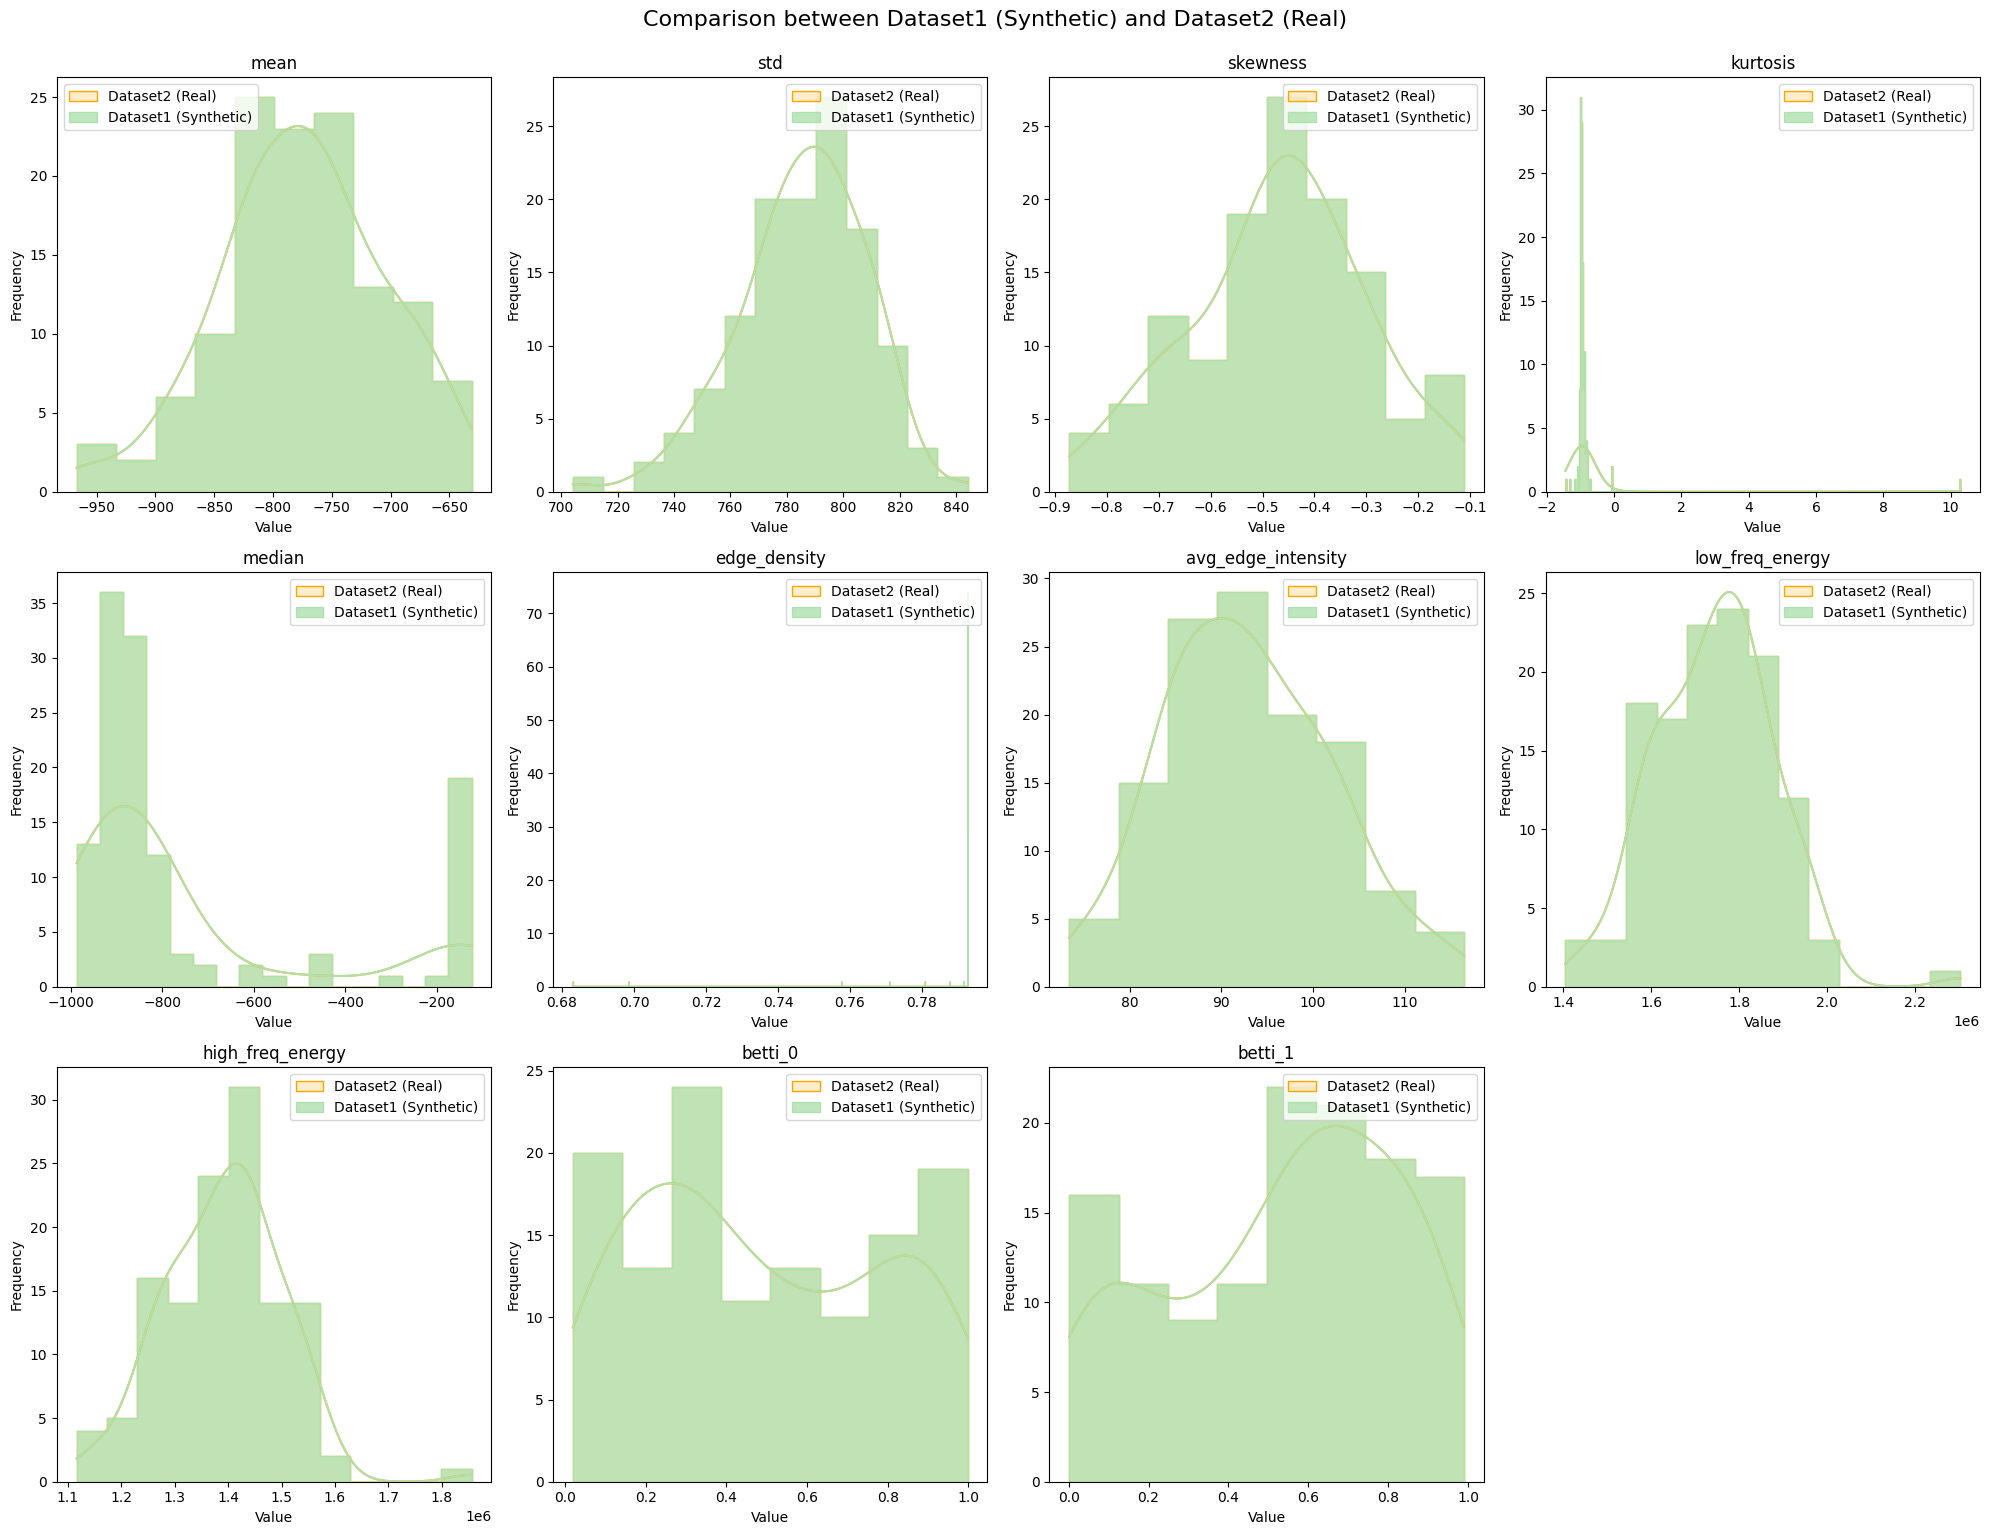

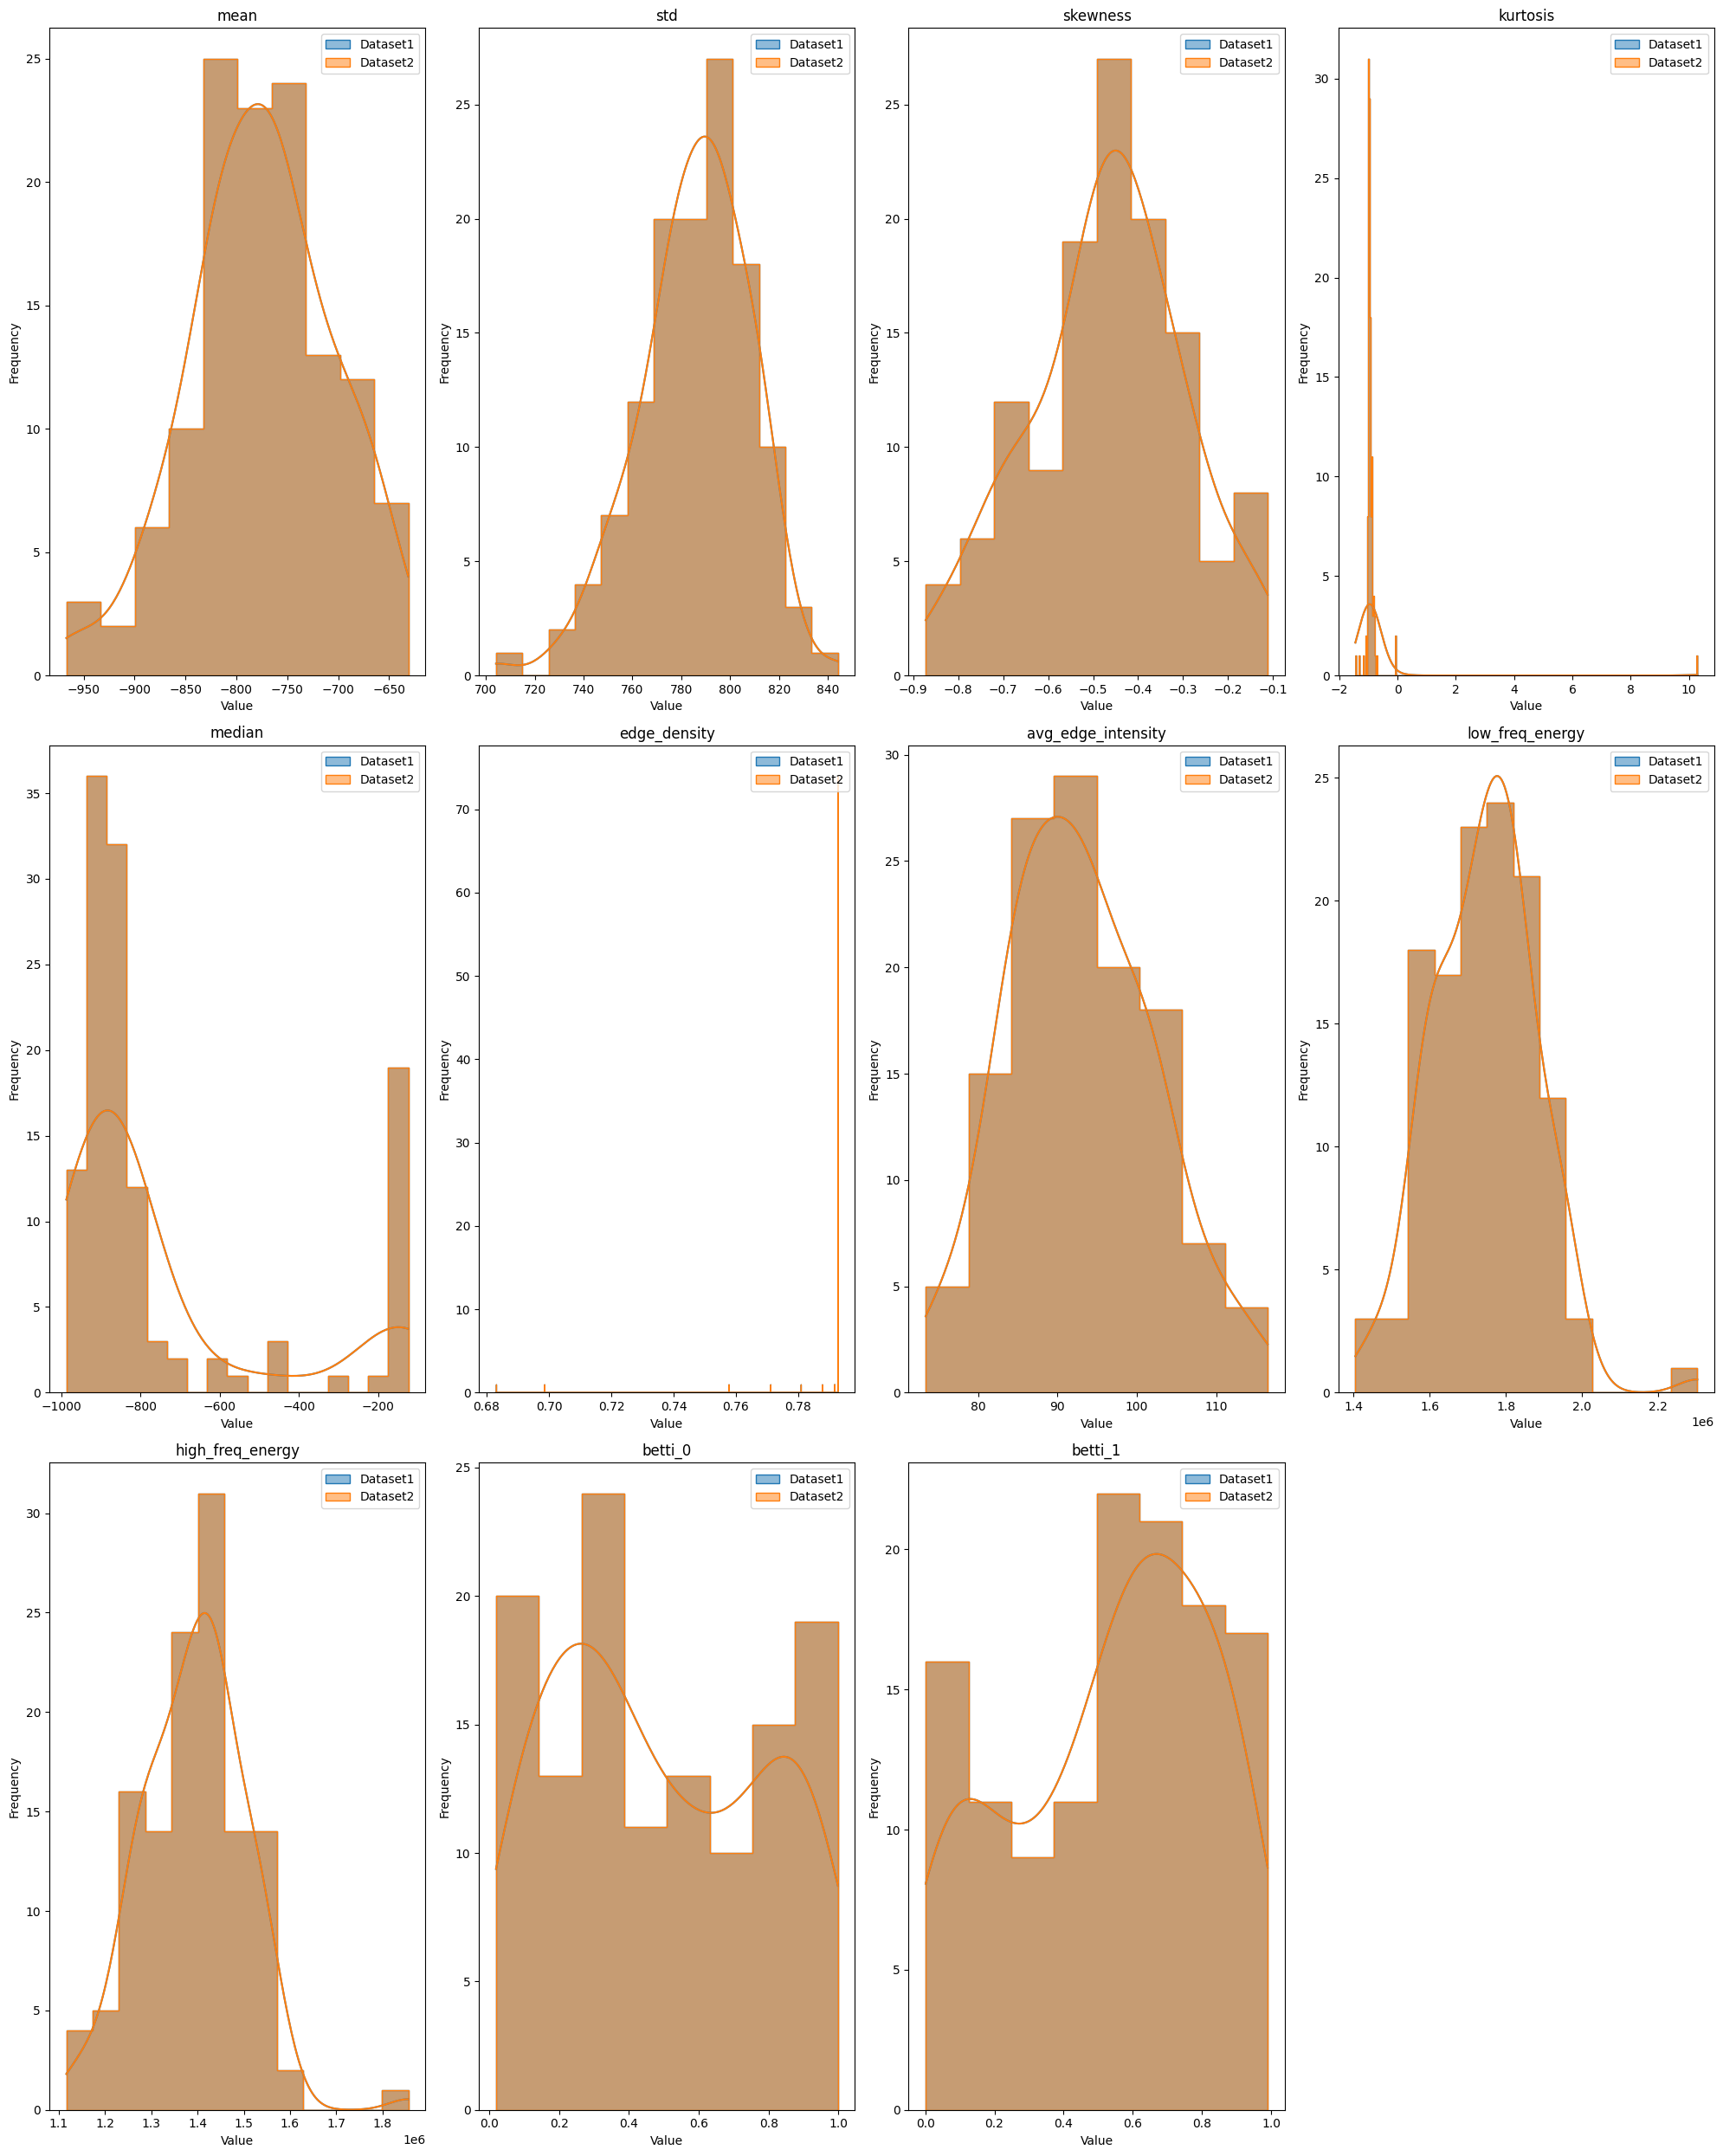

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the paths to the feature CSV files
datasets = {
    'Dataset1': '/content/drive/My Drive/Scorecard_Results/3DFeatures/Sarno-DBT_features.csv',
    'Dataset2': '/content/drive/My Drive/Scorecard_Results/3DFeatures/Sarno-DBT_features.csv'
}

# Define feature columns as they are stored in your DataFrame
feature_columns = [
    'mean', 'std', 'skewness', 'kurtosis', 'median',
    'edge_density', 'avg_edge_intensity', 'low_freq_energy', 'high_freq_energy',
    'betti_0', 'betti_1'
]

# Visualization parameters
real_transparency = 0.2  # Transparency for histograms of real datasets
synthetic_color = '#AFE1AF'  # Distinctive color for synthetic datasets
figsize = (20, 15)  # Overall size of the figure

# Load the dataset features from CSV
dataset_features = {}
for dataset_name, file_path in datasets.items():
    dataset_features[dataset_name] = pd.read_csv(file_path)

def plot_synthetic_vs_real(synthetic, real):
    plt.figure(figsize=figsize)
    for i, column in enumerate(feature_columns):
        plt.subplot(3, 4, i + 1)  # Ensure grid size is sufficient for the number of features
        # Real dataset histogram
        sns.histplot(dataset_features[real][column], kde=True, element='step',
                     label=f'{real} (Real)', color='orange', alpha=real_transparency)
        # Synthetic dataset histogram
        sns.histplot(dataset_features[synthetic][column], kde=True, element='step',
                     label=f'{synthetic} (Synthetic)', color=synthetic_color, alpha=0.8)
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.suptitle(f'Comparison between {synthetic} (Synthetic) and {real} (Real)', fontsize=16, y=1.02)
    plt.show()

def plot_all_datasets():
    plt.figure(figsize=(20, 25))  # Larger grid for better visibility
    for i, column in enumerate(feature_columns):
        plt.subplot(3, 4, i + 1)  # Adjust grid to match the number of features
        for dataset_name, dataset_df in dataset_features.items():
            sns.histplot(dataset_df[column], label=dataset_name, kde=True, element='step')
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Example usage
synthetic_datasets = ['Dataset1']  # Define your synthetic datasets here
real_datasets = ['Dataset2']  # Define your real datasets here

# Execute the plotting functions
for synthetic in synthetic_datasets:
    for real in real_datasets:
        plot_synthetic_vs_real(synthetic, real)  # Compare synthetic and real datasets

plot_all_datasets()  # Plot histograms for all datasets together


In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd

import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import torch.nn.functional
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd

# Define the paths to the datasets
datasets = {
    'Sarno-DBT': '/content/drive/My Drive/CT-2',
    #'Sarno-DBT': '/content/drive/My Drive/CT-2',
}

# Directory for saving features
save_dir = '/content/drive/My Drive/Scorecard_Results/3DFeatures'
os.makedirs(save_dir, exist_ok=True)


class NiftiDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        img = nib.load(file_path).get_fdata()
        img = np.expand_dims(img, axis=0)  # Add channel dimension
        img = torch.tensor(img, dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        return img




In [ ]:
class NiftiDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        img = nib.load(file_path).get_fdata()
        img = np.expand_dims(img, axis=0)  # Add channel dimension
        img = torch.tensor(img, dtype=torch.float32)
        return img

# Define a 3D CNN model (simple ResNet-like architecture for demonstration)
class Simple3DCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=512):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv3d(256, 512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

        # Compute the size of the flattened output
        self.fc_input_size = self._get_conv_output_size((1, 1, 64, 64, 64))

        self.fc = nn.Linear(self.fc_input_size, num_classes)

    def _get_conv_output_size(self, shape):
        with torch.no_grad():
            input_tensor = torch.rand(*shape)
            output = self._forward_features(input_tensor)
            return int(np.prod(output.size()))

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Load the model
model = Simple3DCNN()
model = model.eval()  # Set model to evaluation mode


In [ ]:
!pip install monai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd
from monai.networks.nets import resnet


class NiftiDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        img = nib.load(file_path).get_fdata()
        img = np.expand_dims(img, axis=0)  # Add channel dimension
        img = torch.tensor(img, dtype=torch.float32)
        return img

# Load a pre-trained 3D ResNet model from MONAI
model = resnet.resnet50(spatial_dims=3, n_input_channels=1, num_classes=512)
model = model.eval()  # Set model to evaluation mode

# Define a function to extract features
def extract_features(model, dataloader):
    features = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Extracting features'):
            outputs = model(batch)
            features.append(outputs.numpy())
    features = np.concatenate(features, axis=0)
    return features

# Process each dataset
for dataset_name, dataset_path in datasets.items():
    all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.nii')]
    dataset = NiftiDataset(all_files)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    features = extract_features(model, dataloader)

    # Save features to CSV
    feature_columns = [f'feature_{i}' for i in range(features.shape[1])]
    dataset_df = pd.DataFrame(features, columns=feature_columns)
    output_path = os.path.join(save_dir, f'{dataset_name}_features.csv')
    dataset_df.to_csv(output_path, index=False)

    print(f"Extracted features for {dataset_name}:")
    print(dataset_df.head())

# Further operations such as plotting or advanced analysis can continue from here


Extracting features: 100%|██████████| 125/125 [1:03:08<00:00, 30.31s/it]

Extracted features for Sarno-DBT:
     feature_0    feature_1   feature_2    feature_3    feature_4  \
0  3056.770264  6755.289062  617.327881 -6699.710938 -2848.062500   
1  2155.102783  6062.356445  935.475342 -6215.103516 -3564.874268   
2  2516.656738  5041.559570  763.935181 -5980.496094 -2899.530273   
3  2398.439697  5084.147461  737.412720 -6070.822266 -2688.722656   
4  2121.976074  6160.131348  837.856445 -6180.863770 -3710.590332   

     feature_5     feature_6     feature_7    feature_8    feature_9  ...  \
0 -9629.539062 -10897.230469 -10305.621094 -3518.406738  4732.588867  ...   
1 -7649.433594  -9447.595703  -9001.683594 -3179.596680  4146.085938  ...   
2 -8075.719727  -7191.532227  -8380.924805 -2831.960449  3215.256104  ...   
3 -8378.342773  -7427.945312  -8491.433594 -2803.557861  3424.044434  ...   
4 -7871.219727  -9640.801758  -9118.017578 -3135.171875  4071.160156  ...   

   feature_502  feature_503  feature_504  feature_505  feature_506  \
0  7542.732422 -13

In [ ]:
print(output_path)

/content/drive/My Drive/Scorecard_Results/3DFeatures/Sarno-DBT_features.csv


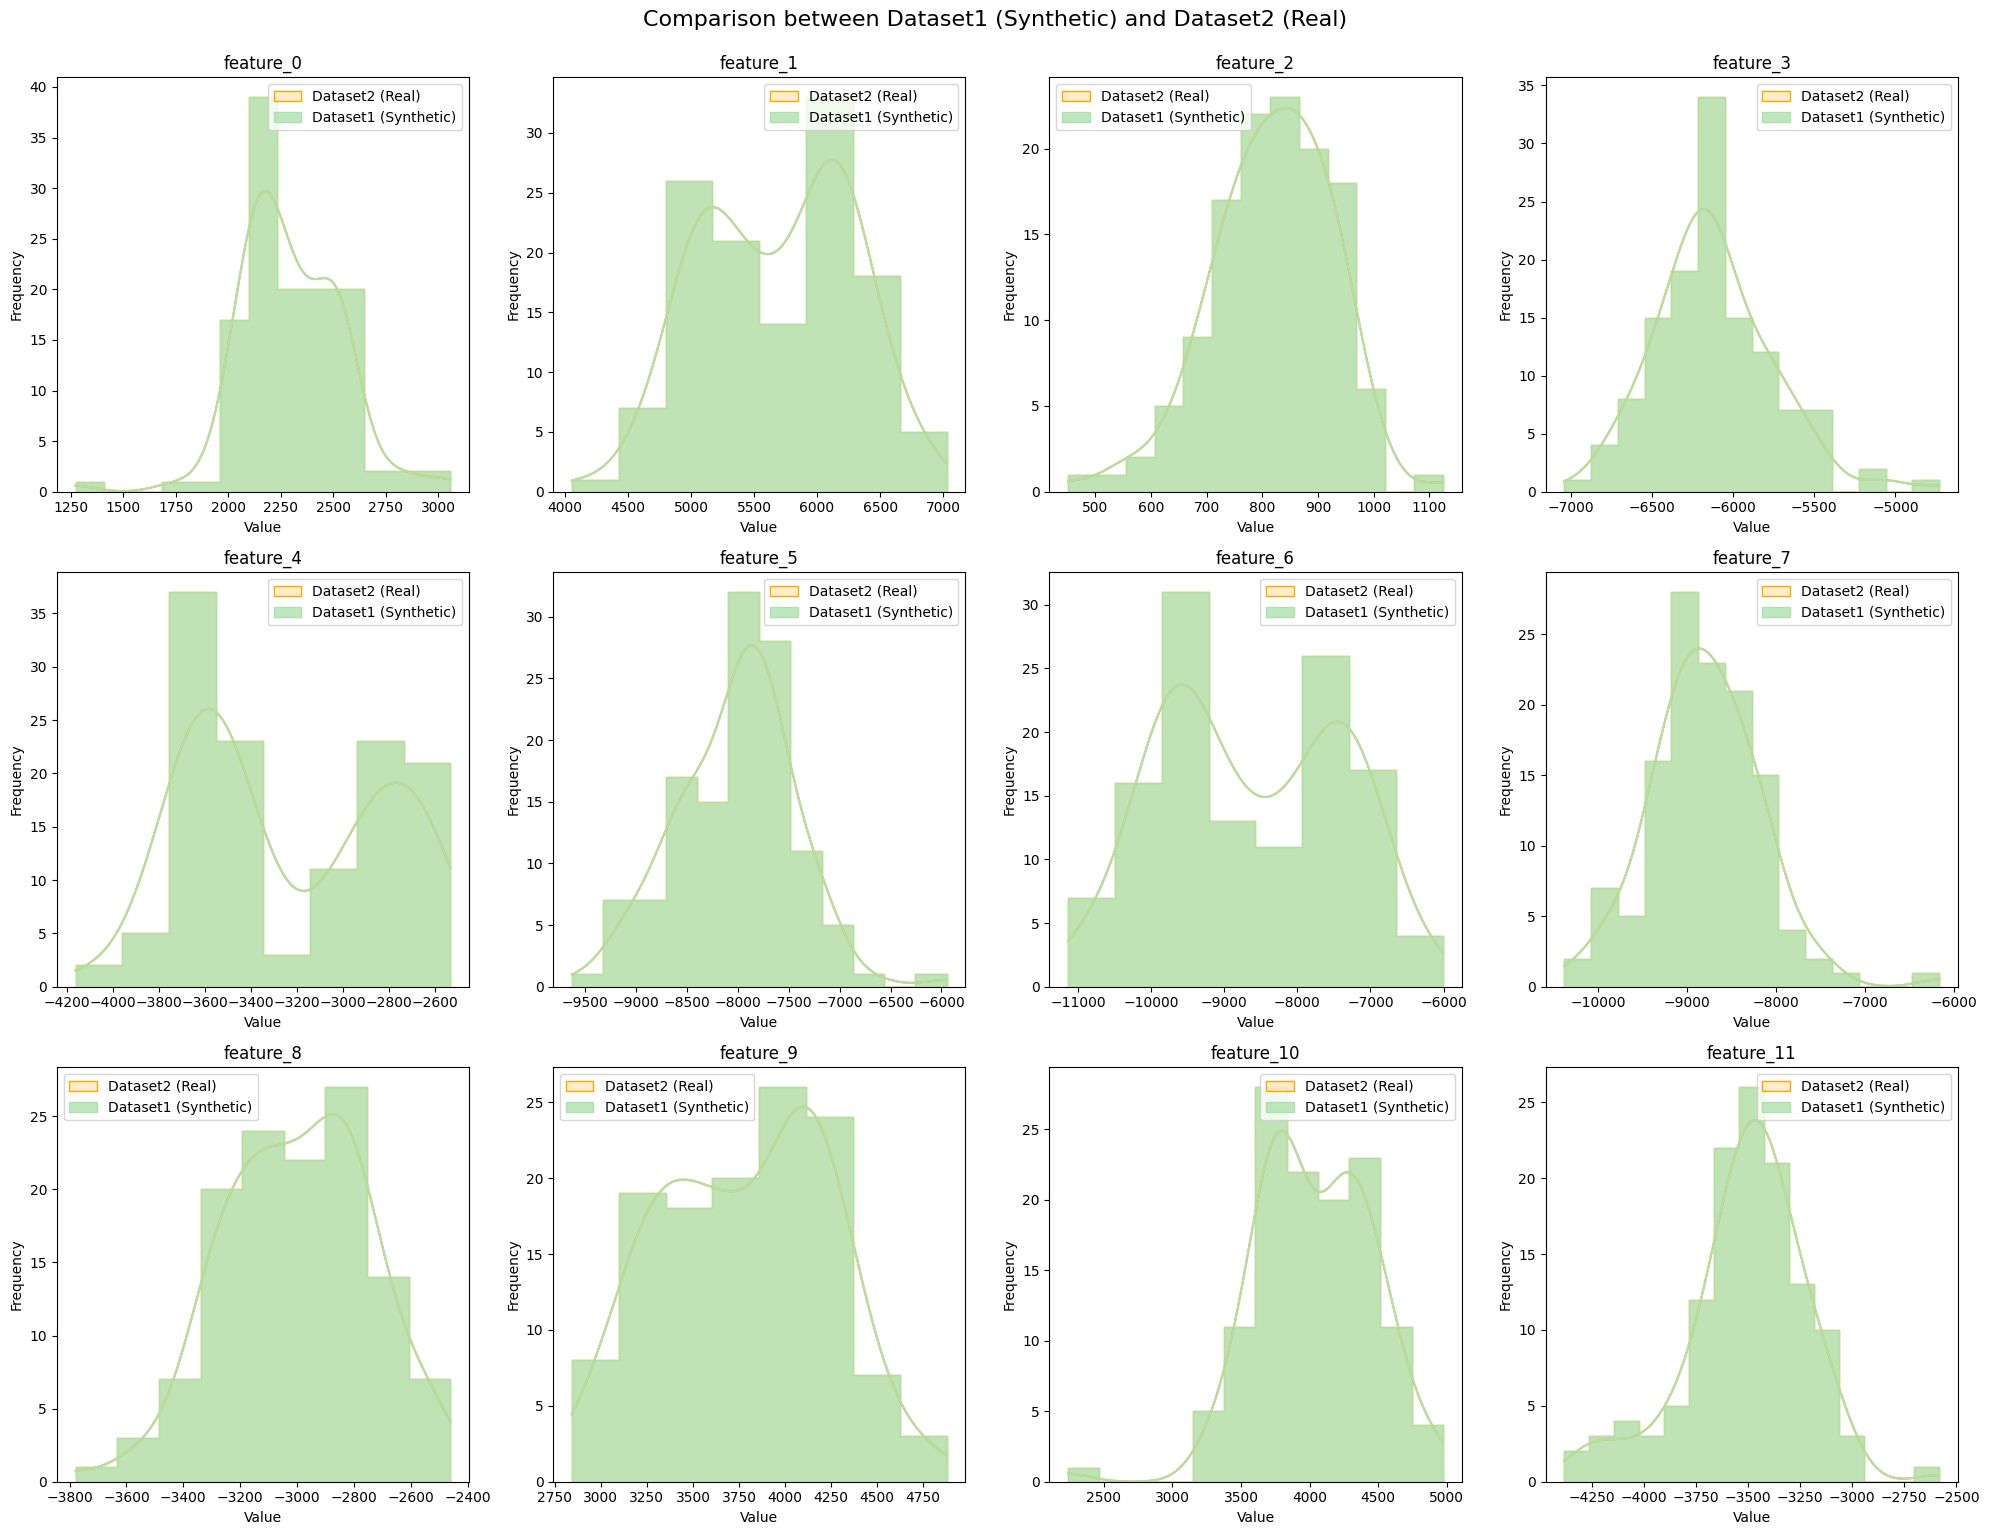

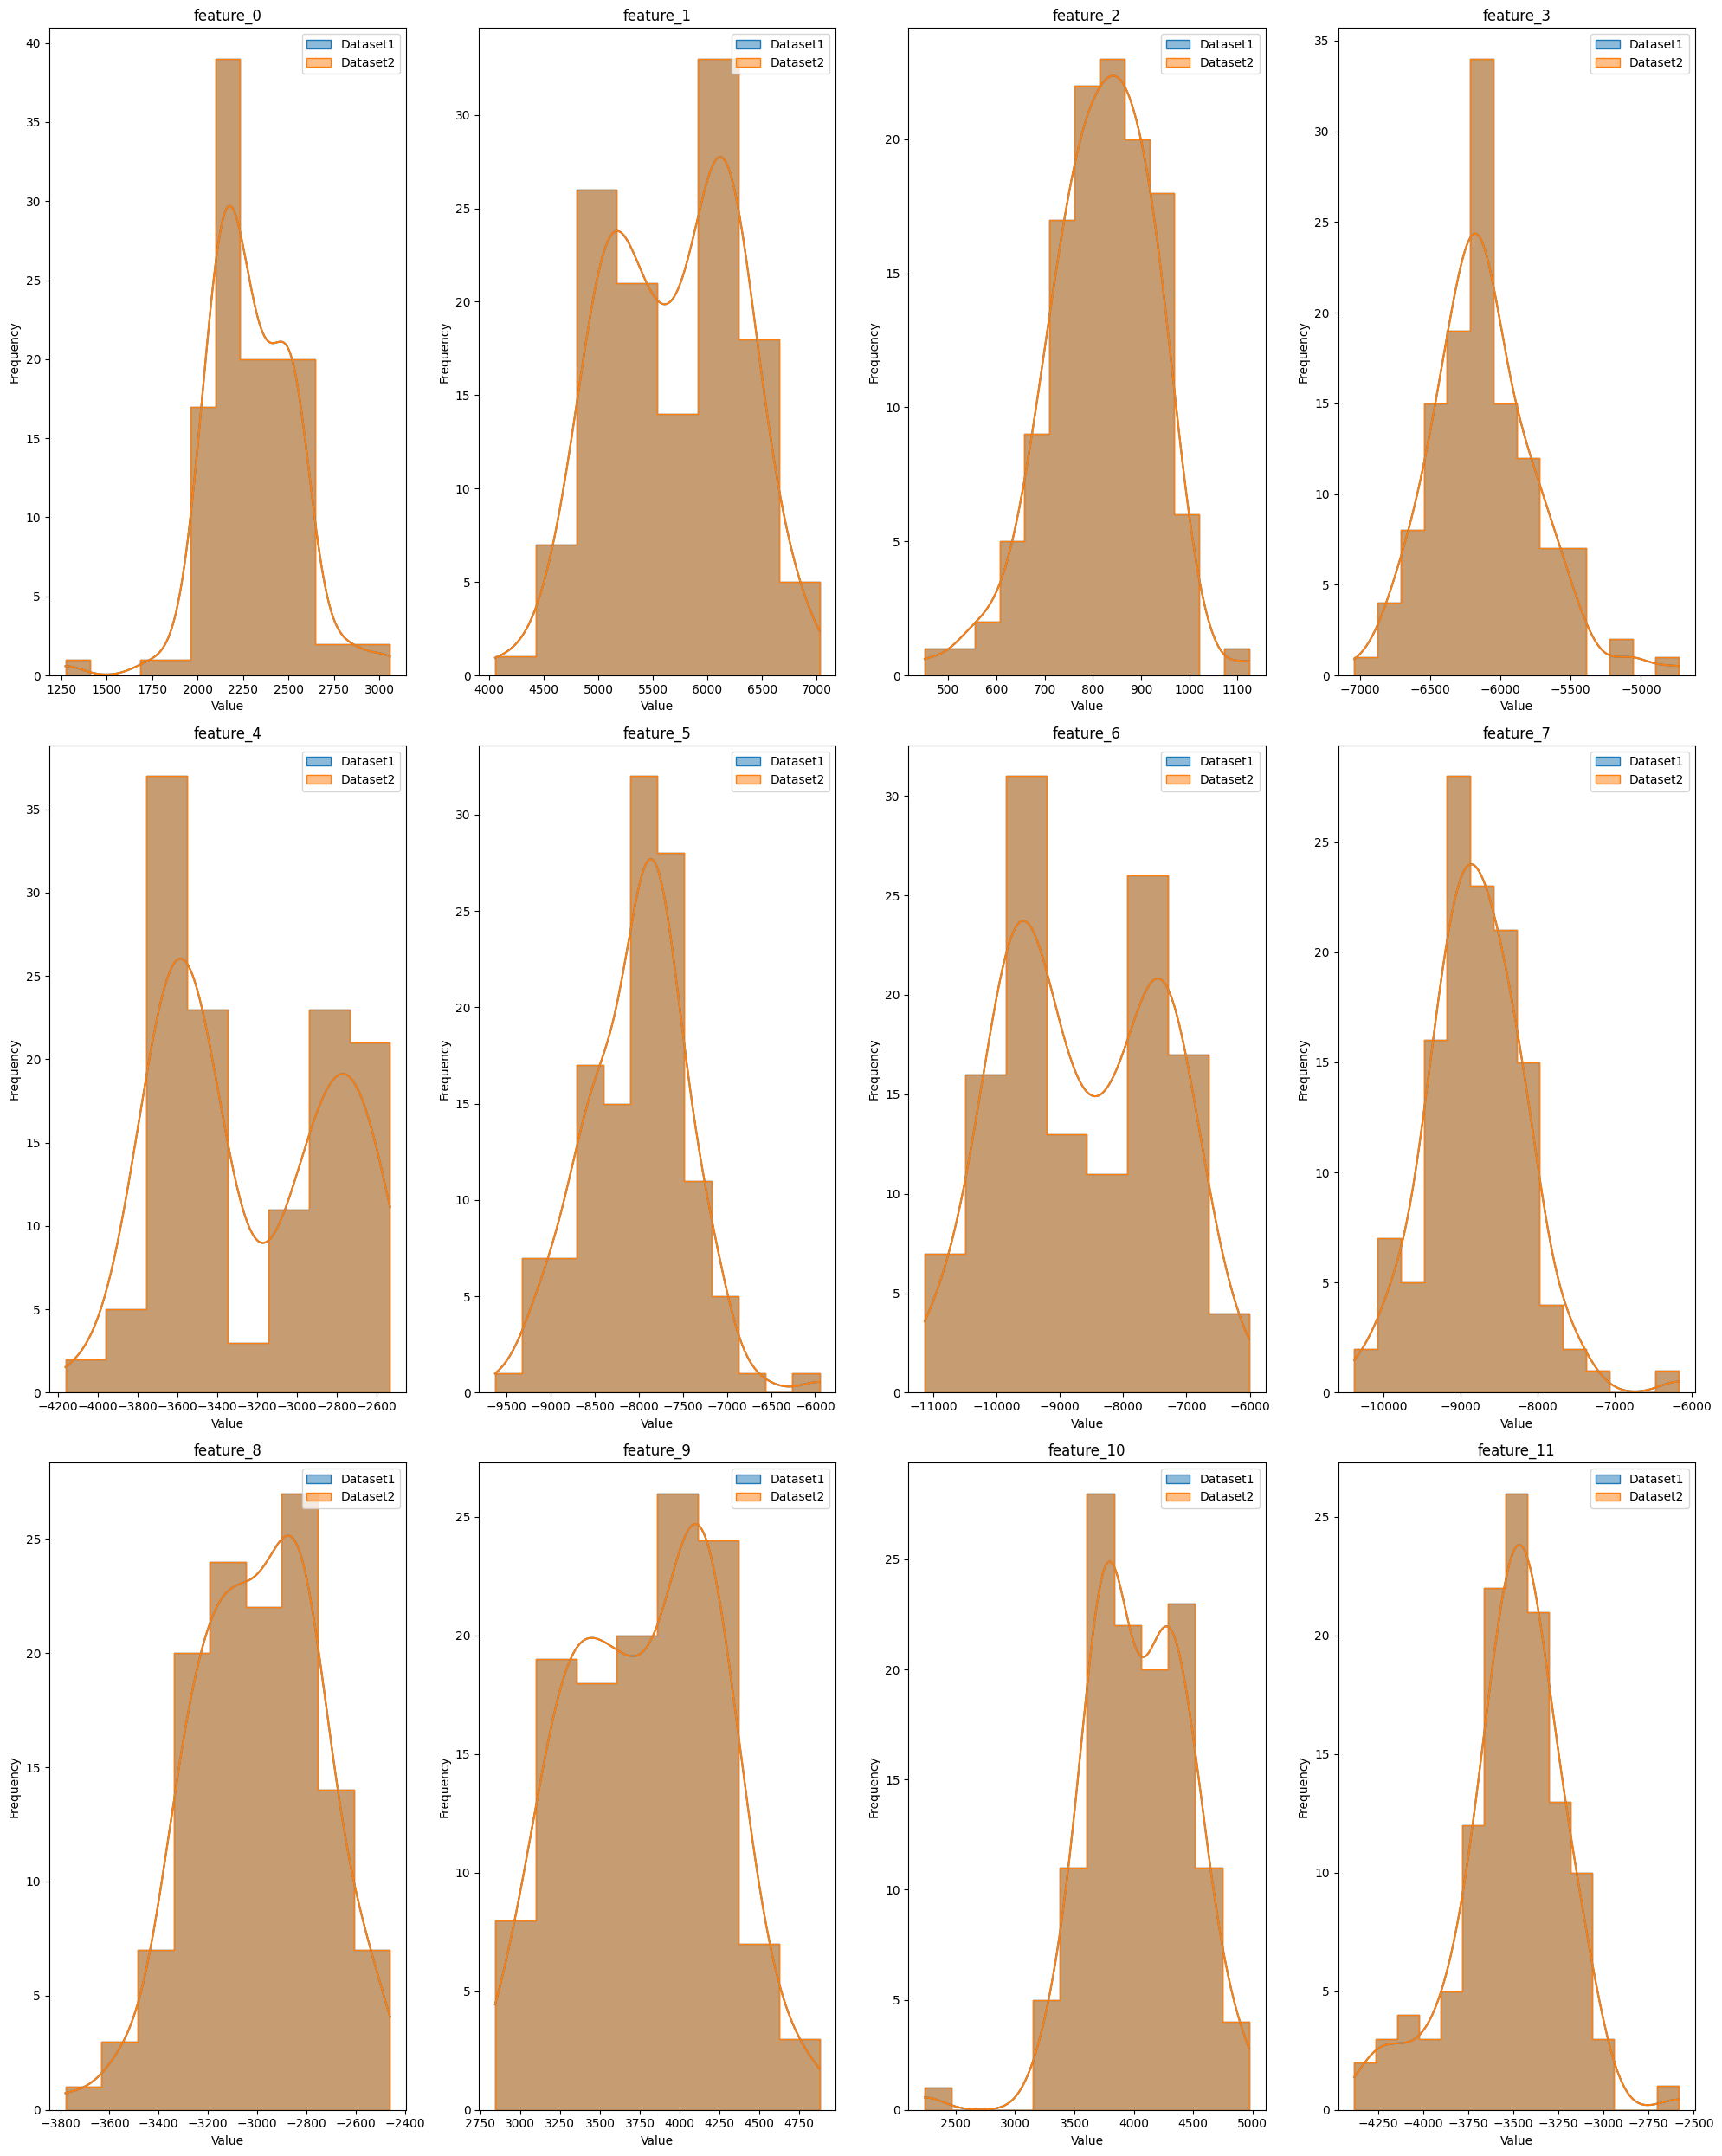

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the paths to the feature CSV files
datasets = {
    'Dataset1': '/content/drive/My Drive/Scorecard_Results/3DFeatures/Sarno-DBT_features.csv',
    'Dataset2': '/content/drive/My Drive/Scorecard_Results/3DFeatures/Sarno-DBT_features.csv'
}

# Load the dataset features from CSV
dataset_features = {}
for dataset_name, file_path in datasets.items():
    dataset_features[dataset_name] = pd.read_csv(file_path)

# Define feature columns (assuming 512 features for a typical 3D CNN)
feature_columns = [f'feature_{i}' for i in range(512)]  # Adjust based on the actual number of features

# Visualization parameters
figsize = (20, 15)  # Overall size of the figure

def plot_synthetic_vs_real(synthetic, real):
    plt.figure(figsize=figsize)
    for i, column in enumerate(feature_columns[:12]):  # Plot only the first 12 features for clarity
        plt.subplot(3, 4, i + 1)  # Ensure grid size is sufficient for the number of features
        # Real dataset histogram
        sns.histplot(dataset_features[real][column], kde=True, element='step',
                     label=f'{real} (Real)', color='orange', alpha=0.2)
        # Synthetic dataset histogram
        sns.histplot(dataset_features[synthetic][column], kde=True, element='step',
                     label=f'{synthetic} (Synthetic)', color='#AFE1AF', alpha=0.8)
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.suptitle(f'Comparison between {synthetic} (Synthetic) and {real} (Real)', fontsize=16, y=1.02)
    plt.show()

def plot_all_datasets():
    plt.figure(figsize=(20, 25))  # Larger grid for better visibility
    for i, column in enumerate(feature_columns[:12]):  # Plot only the first 12 features for clarity
        plt.subplot(3, 4, i + 1)  # Adjust grid to match the number of features
        for dataset_name, dataset_df in dataset_features.items():
            sns.histplot(dataset_df[column], label=dataset_name, kde=True, element='step')
        plt.legend()
        plt.title(column)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Example usage
synthetic_datasets = ['Dataset1']  # Define your synthetic datasets here
real_datasets = ['Dataset2']  # Define your real datasets here

# Execute the plotting functions
for synthetic in synthetic_datasets:
    for real in real_datasets:
        plot_synthetic_vs_real(synthetic, real)  # Compare synthetic and real datasets

plot_all_datasets()  # Plot histograms for all datasets together


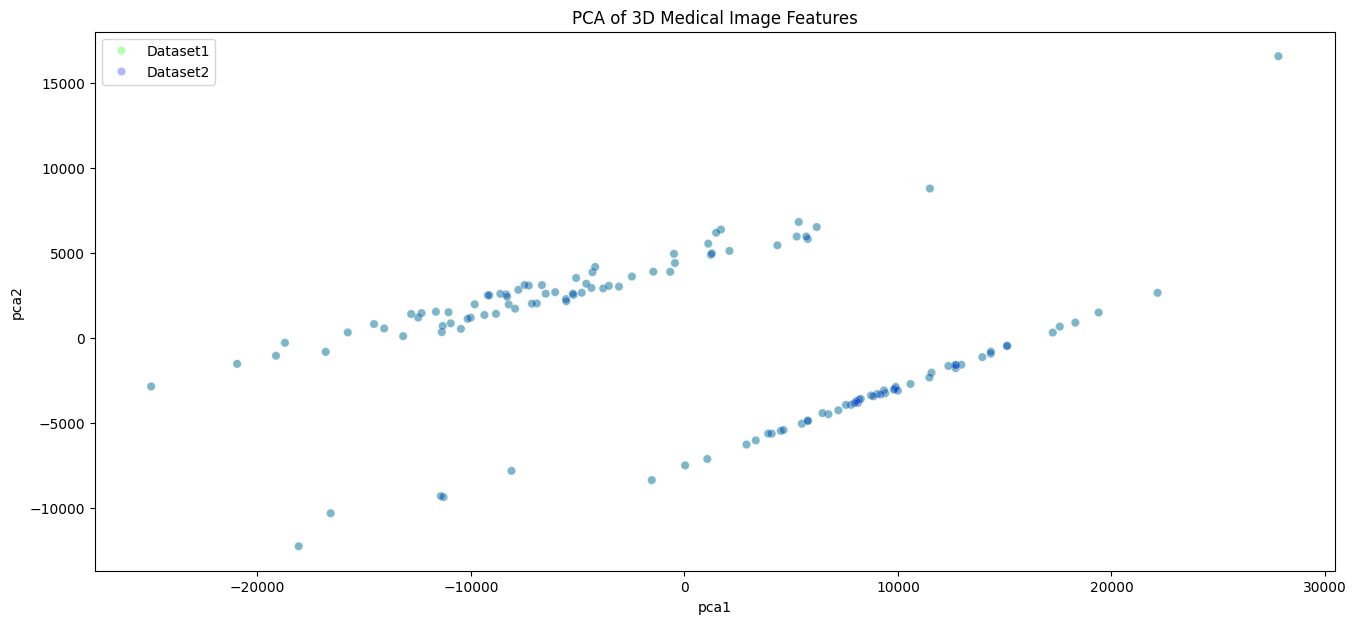

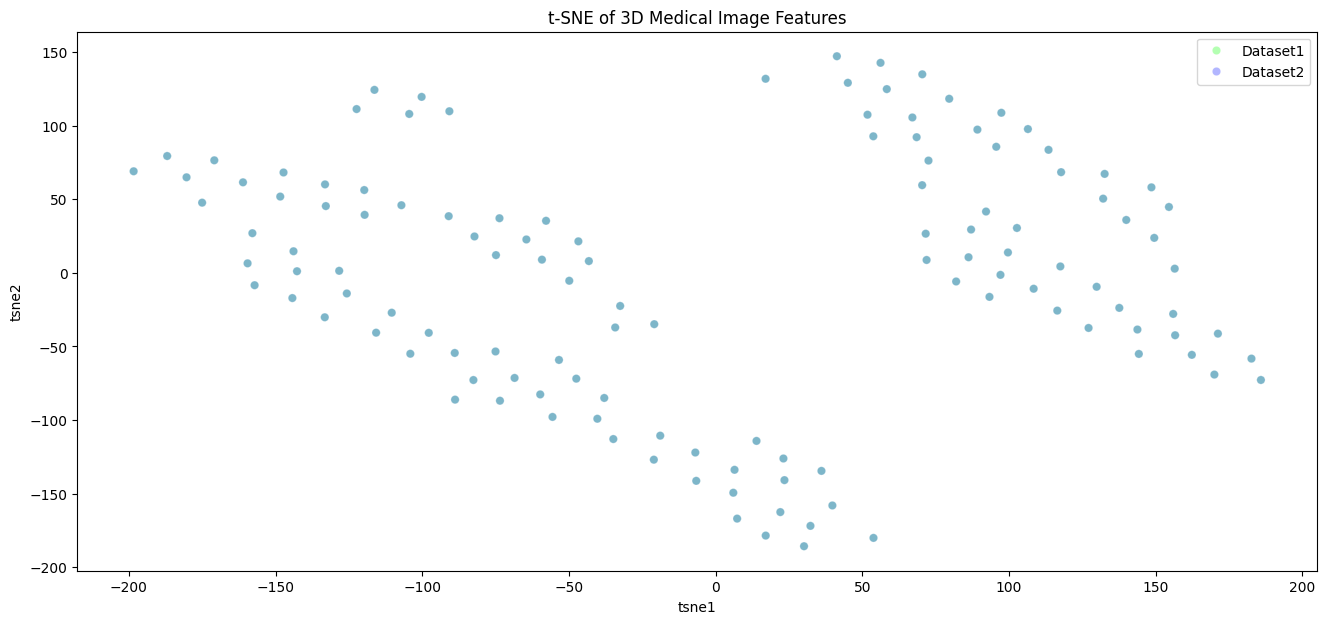

In [ ]:
# Load the dataset features from CSV for visualization
dataset_features = {}
for dataset_name, file_path in datasets.items():
    dataset_features[dataset_name] = pd.read_csv(file_path)

# Combine datasets for visualization
combined_features = pd.concat([dataset_features[name] for name in datasets.keys()], ignore_index=True)
labels = np.concatenate([[name] * len(dataset_features[name]) for name in datasets.keys()])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_features)
combined_features['pca1'] = pca_result[:, 0]
combined_features['pca2'] = pca_result[:, 1]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(combined_features.iloc[:, :-2])  # Exclude PCA columns
combined_features['tsne1'] = tsne_result[:, 0]
combined_features['tsne2'] = tsne_result[:, 1]

# Plot PCA
plt.figure(figsize=(16, 7))
sns.scatterplot(
    x='pca1', y='pca2',
    hue=labels,
    palette=sns.color_palette("hsv", len(datasets)),
    data=combined_features,
    legend="full",
    alpha=0.3
)
plt.title('PCA of 3D Medical Image Features')
plt.show()

# Plot t-SNE
plt.figure(figsize=(16, 7))
sns.scatterplot(
    x='tsne1', y='tsne2',
    hue=labels,
    palette=sns.color_palette("hsv", len(datasets)),
    data=combined_features,
    legend="full",
    alpha=0.3
)
plt.title('t-SNE of 3D Medical Image Features')
plt.show()